# Entrenamiento y comparativa de diferentes modelos de Redes Neuronales Convolucionales (CNN)

En este cuaderno vamos a proceder con el entrenamiento de diferentes arquitecturas de red neuronal convolucional con las imágenes que preprocesamos en el cuaderno ``image_loading.ipynb``. Para ello, haremos uso de la librería ``Keras`` para implementar tres arquitecturas diferentes. En concreto entrenaremos y compararemos las arquitecturas Le-Net 5, VGG-16 y Lu-Net en cuatro experimentos con diferentes características. 

La explicación de cada una de las arquitecturas se reserva a la memoria correspondiente a este trabajo. Sin embargo, a continuación en cada subapartado de este cuaderno realizaremos una breve explicación de cada uno de los experimentos llevados a cabo.

In [ ]:
!pip install keras-cv

import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras_cv.layers import DropBlock2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.regularizers import L2
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') 
tf.config.run_functions_eagerly(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [ ]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def data_augmentation_with_class(imgs, classes, augs_yes, augs_no, imgs_trans): 
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        if y == 1:
            iters = augs_yes 
        else:
            iters = augs_no 
        for _ in range(iters):
          tmp_img = imgs_trans(image=img)["image"]
          new_images.append(tmp_img)
          new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def balanced_accuracy(y_true, y_pred):
    # print(np.unique(y_true.numpy()))
    # print(np.unique(np.round(y_pred.numpy())))
    return balanced_accuracy_score(y_true.numpy(), np.round(y_pred.numpy()))

def fit_evaluate(model, X_train, X_test, X_val, y_val, y_train, y_test, batch_size=32, epochs=100):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    scores_model = model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics, epochs=100):
    if len(metrics) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(range(1, epochs+1), df[metrics[0]], 'b-', label='Train')
        ax.plot(range(1, epochs+1), df[f'val_{metrics[0]}'], 'r-', label='Validation')
        ax.set_title(metrics[0])
        ax.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
        for i, metric in zip(range(len(metrics)), metrics):
            ax[i].plot(range(1, epochs+1), df[metric], 'b-', label='Train')
            ax[i].plot(range(1, epochs+1), df[f'val_{metric}'], 'r-', label='Validation')
            ax[i].set_title(metric)
            ax[i].legend()
        plt.show()

## Experimento 1: aproximación *naive*

En este primer experimento proponemos una aproximación *naive* al entrenamiento de las redes neuronales. Como sabemos, una de las problemáticas más frecuentes durante el entrenamiento y evaluación de una red neuronal es su clara tendencia al *overfitting*. En el contexto del *machine learning* y el *deep learning*, el *overfitting* se entiende como la tendencia de un modelo a memorizar las muestras del conjunto de entrenamiento y sus características (incluido el ruido de dichas muestras), ofreciendo sin embargo un muy rendimiento pobre en conjuntos de *test* o en muestras no vistas previamente. Esta problemática es incluso más pronunciada cuando la red neuronal presenta una arquitectura compleja con un alto número de parámetros. 

Este tipo de problemas puede solucionarse mediante diferentes técnicas como la *regularización*, la recolección de un mayor número de muestras para crear un *dataset* más grande, o incluso la generación de muestras de forma artificial. Sin embargo, a continuación mostramos el procedimiento de entrenamiento y evaluación de las diferentes arquitecturas con el *dataset* original para comprobar si efectivamente estas arquitecturas presentan *overfitting* debido a su complejidad y número de parámetros. Únicamente utilizaremos un ``StandardScaler`` con el objetivo de mejorar la estabilidad del modelo durante el proceso de entrenamiento.

Otro aspecto importante será la partición del conjunto de datos en conjuntos de entrenamiento, validación y prueba. En este caso hemos optado por un *split* con el 70% de las muestras para el conjunto de entrenamiento, y el 30% restante para el conjunto de test. Del 70% de las muestras de entrenamiento, un 20% se reservará para validación. Además, al estar tratando con un *dataset* ligeramente desbalanceado (61% de las muestras corresponden a imágenes con tejido canceroso, el resto a imágenes que no presentan ese tipo de tejido), realizaremos un *split* con estratificación. Mediante este tipo de *split* garantizamos que en todos los conjuntos se mantiene la proporción de muestras de cada clase.

In [ ]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(N, -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(N, SIZE_H, SIZE_V))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [ ]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 224, 224)
y_train shape (123,)
X_val shape: (31, 224, 224)
y_val shape (31,)
X_test shape: (66, 224, 224)
y_test shape: (66,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

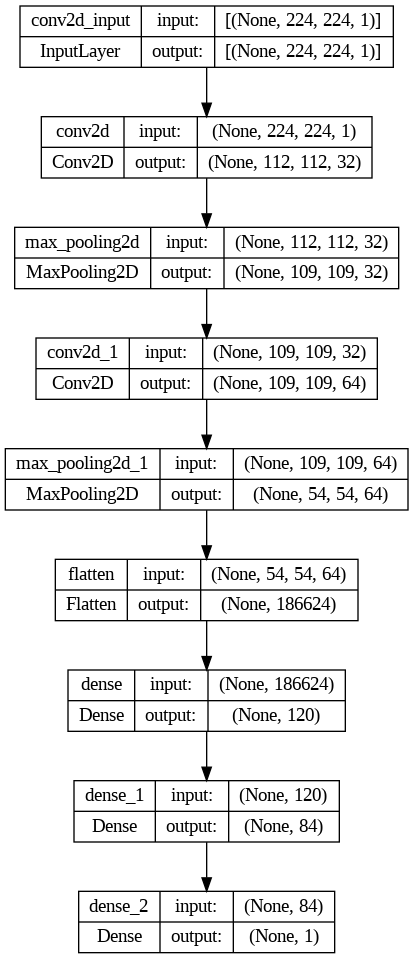

In [ ]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

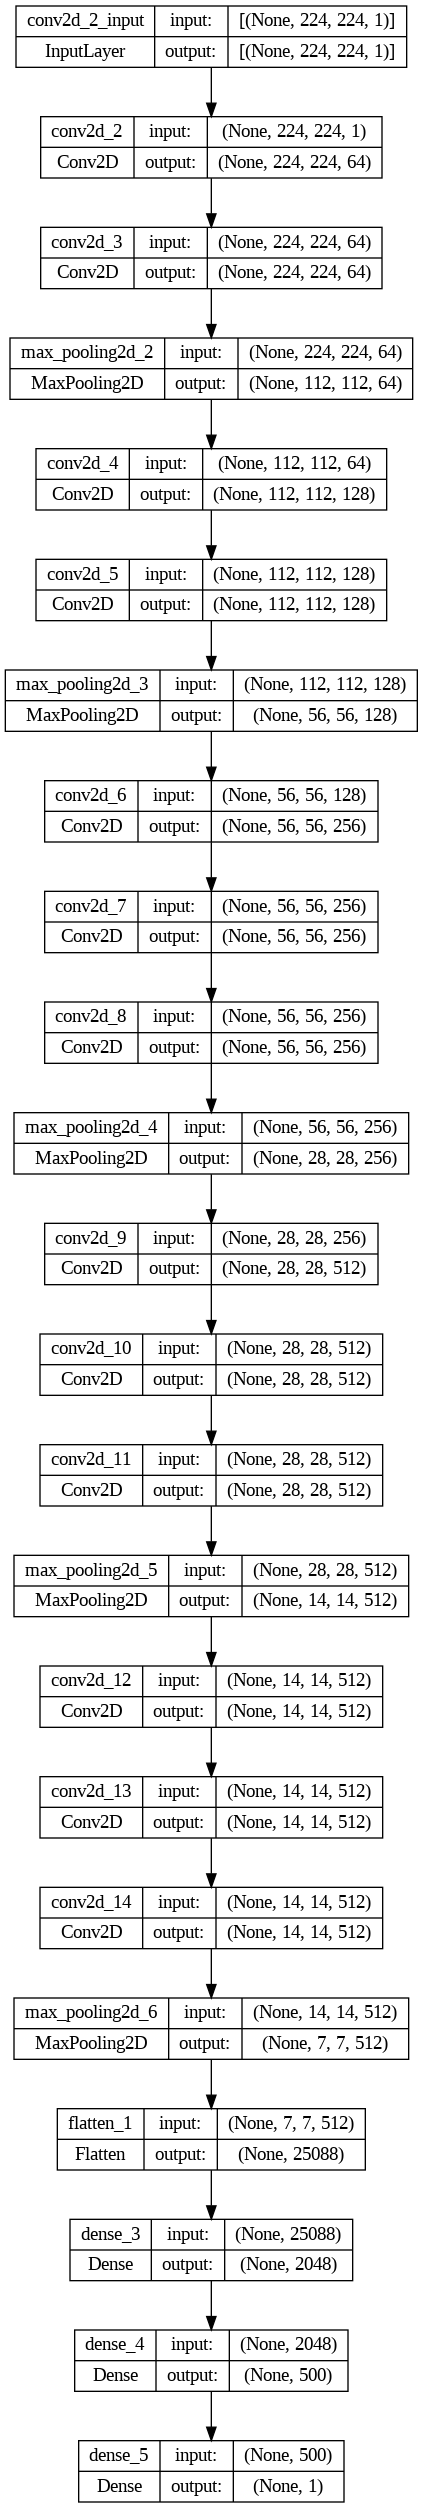

In [ ]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=2048, activation='relu'),
    Dense(units=500, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

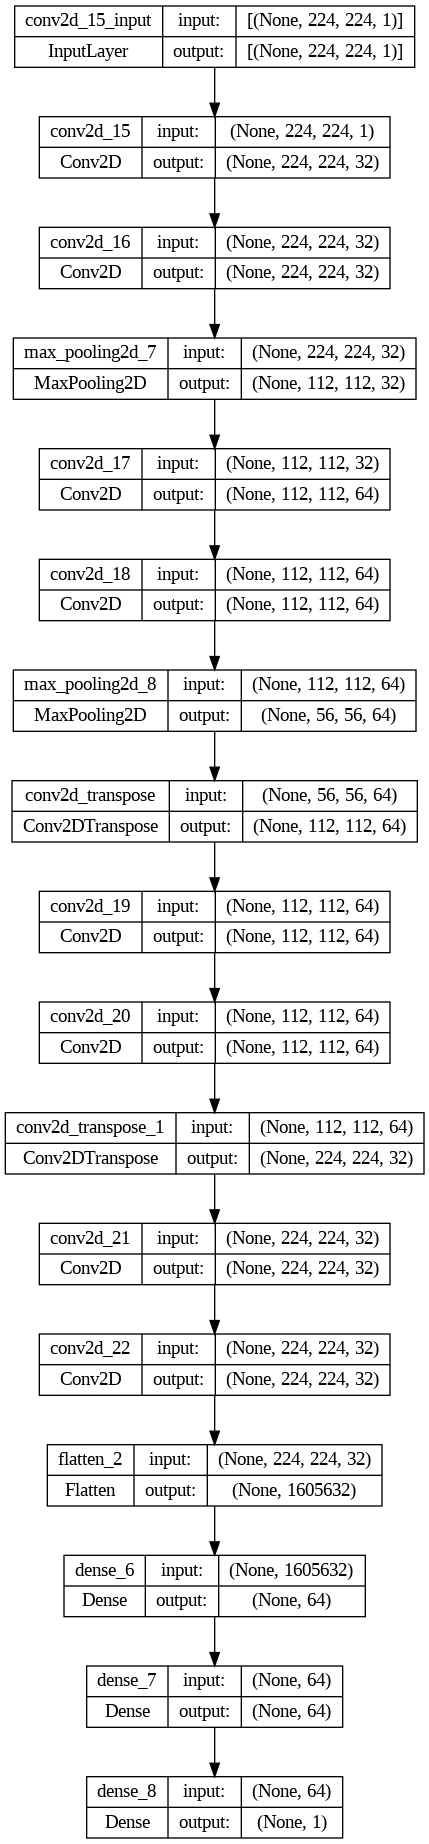

In [ ]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=64, activation='sigmoid'),
    Dense(units=64, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

Tanto para este experimento como para todos los restantes, haremos uso de un optimizador ``Adam`` con una tasa de aprendizaje de ``1e-5``. En cuanto a las métricas, calcularemos la precisión, exactitud, exhaustividad y exactitud balanceda. En este caso, la exactitud balanceada ofrece una medida más representativa del rendimiento de las redes, pues como hemos visto previamente, el *dataset* se encuentra ligeramente desbalanceado. Finalmente, usaremos la ``binary_crossentropy`` como función de pérdida pues nos encontramos frente a un problema de clasificación binaria. 

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-5)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 6s 171ms/step - loss: 0.6557 - precision: 0.6596 - binary_accuracy: 0.6341 - recall: 0.8267 - balanced_accuracy: 0.5647 - val_loss: 0.6437 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 0s 96ms/step - loss: 0.6337 - precision: 0.6271 - binary_accuracy: 0.6341 - recall: 0.9867 - balanced_accuracy: 0.5652 - val_loss: 0.5961 - val_precision: 0.7500 - val_binary_accuracy: 0.7742 - val_recall: 0.9474 - val_balanced_accuracy: 0.7237
Epoch 3/100
4/4 [==============================] - 0s 101ms/step - loss: 0.5694 - precision: 0.7030 - binary_accuracy: 0.7236 - recall: 0.9467 - balanced_accuracy: 0.6603 - val_loss: 0.5782 - val_precision: 0.7200 - val_binary_accuracy: 0.7419 - val_recall: 0.9474 - val_balanced_accuracy: 0.6820
Epoch 4/100
4/4 [==============================] - 0s 96ms/step - loss: 0.5218 - precision: 0.7255 - binary_ac

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.655655,0.659574,0.634146,0.826667,0.564651,0.643703,0.612903,0.612903,1.000000,0.500000
1,0.633705,0.627119,0.634146,0.986667,0.565179,0.596088,0.750000,0.774194,0.947368,0.723684
2,0.569375,0.702970,0.723577,0.946667,0.660281,0.578200,0.720000,0.741935,0.947368,0.682018
3,0.521789,0.725490,0.764228,0.986667,0.706992,0.566418,0.782609,0.806452,0.947368,0.765351
4,0.474027,0.793478,0.829268,0.973333,0.786126,0.568362,0.800000,0.677419,0.631579,0.690789


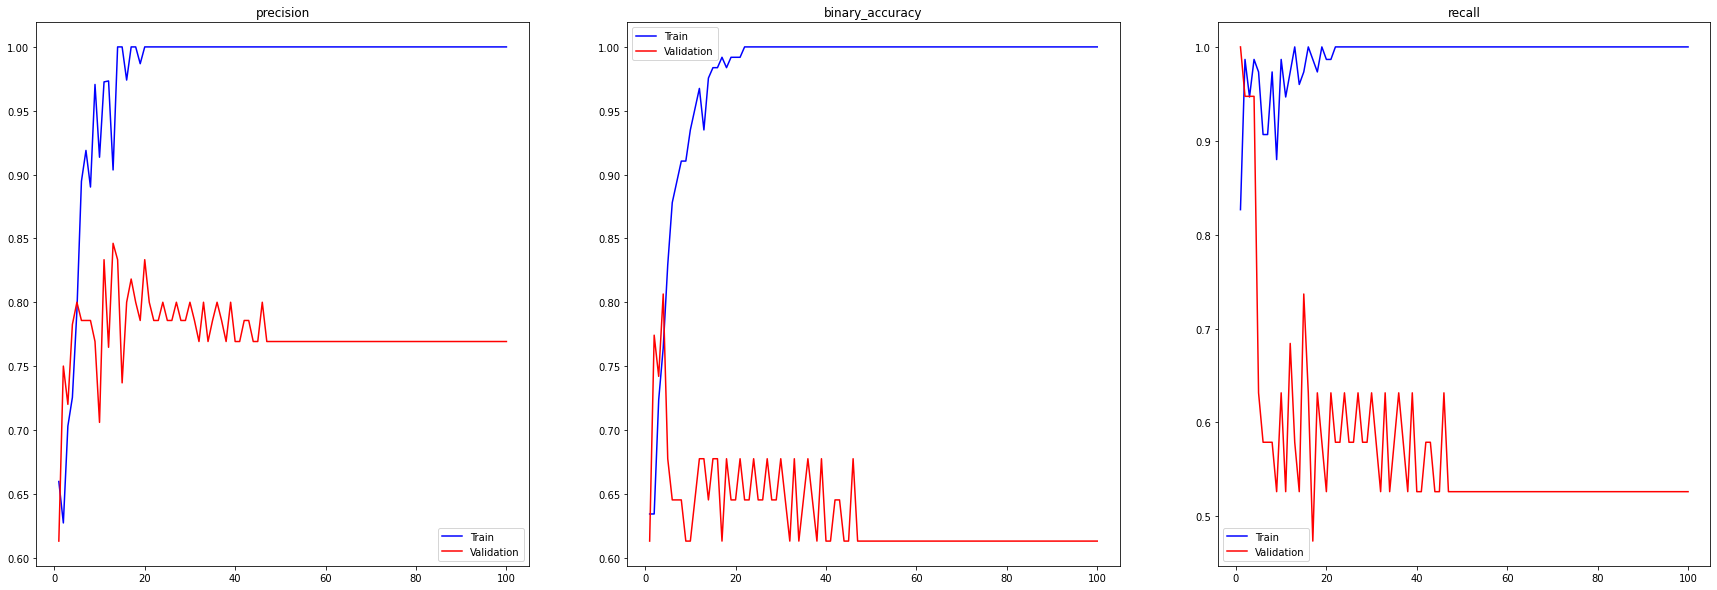

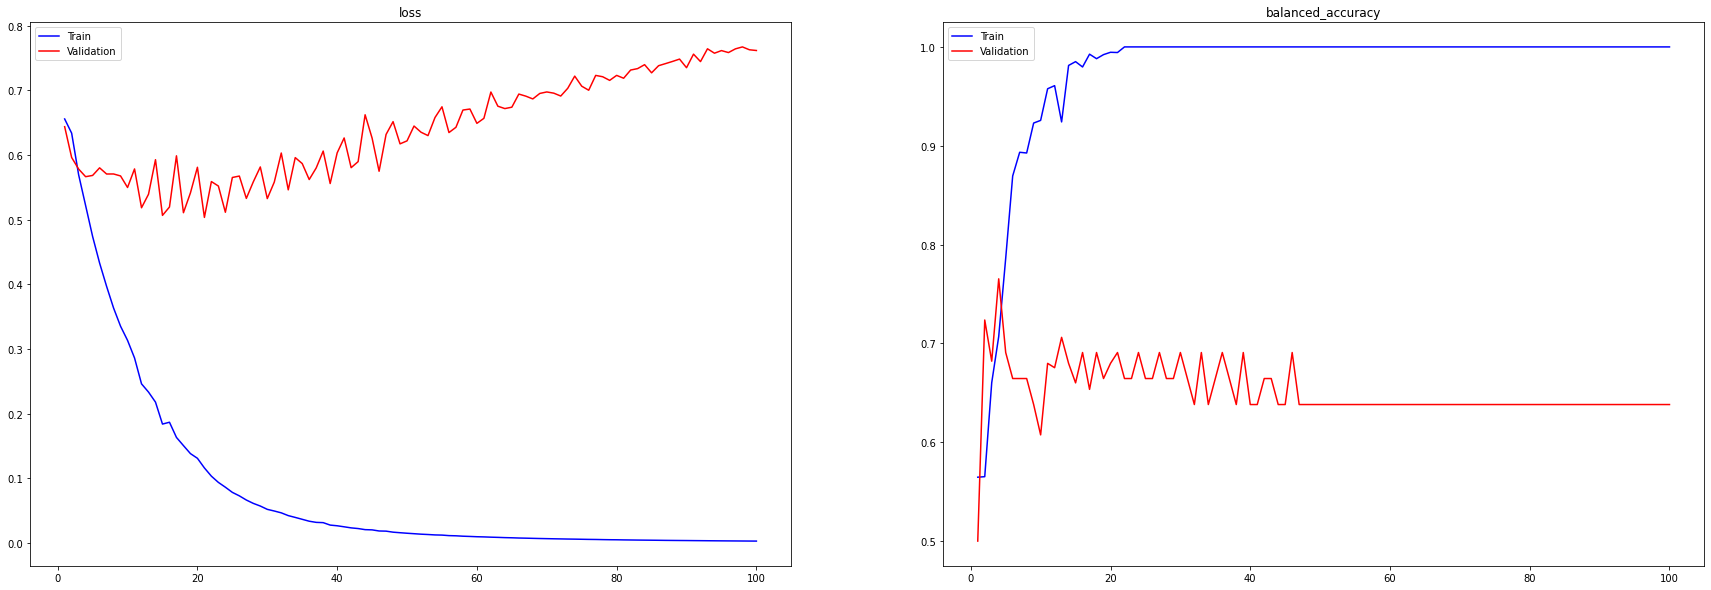

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 4s 754ms/step - loss: 0.6894 - precision: 0.6538 - binary_accuracy: 0.6032 - recall: 0.7391 - balanced_accuracy: 0.5000 - val_loss: 0.6743 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 1s 156ms/step - loss: 0.6725 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6379 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 1s 152ms/step - loss: 0.6512 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6407 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 1s 153ms/step - loss: 0.6432 - precision: 0.6098 - binary_

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.689376,0.653846,0.603175,0.73913,0.5,0.674251,0.612903,0.612903,1.0,0.5
1,0.672481,0.609756,0.609756,1.00000,0.5,0.637948,0.612903,0.612903,1.0,0.5
2,0.651225,0.609756,0.609756,1.00000,0.5,0.640725,0.612903,0.612903,1.0,0.5
3,0.643231,0.609756,0.609756,1.00000,0.5,0.623921,0.612903,0.612903,1.0,0.5
4,0.630285,0.609756,0.609756,1.00000,0.5,0.623186,0.612903,0.612903,1.0,0.5


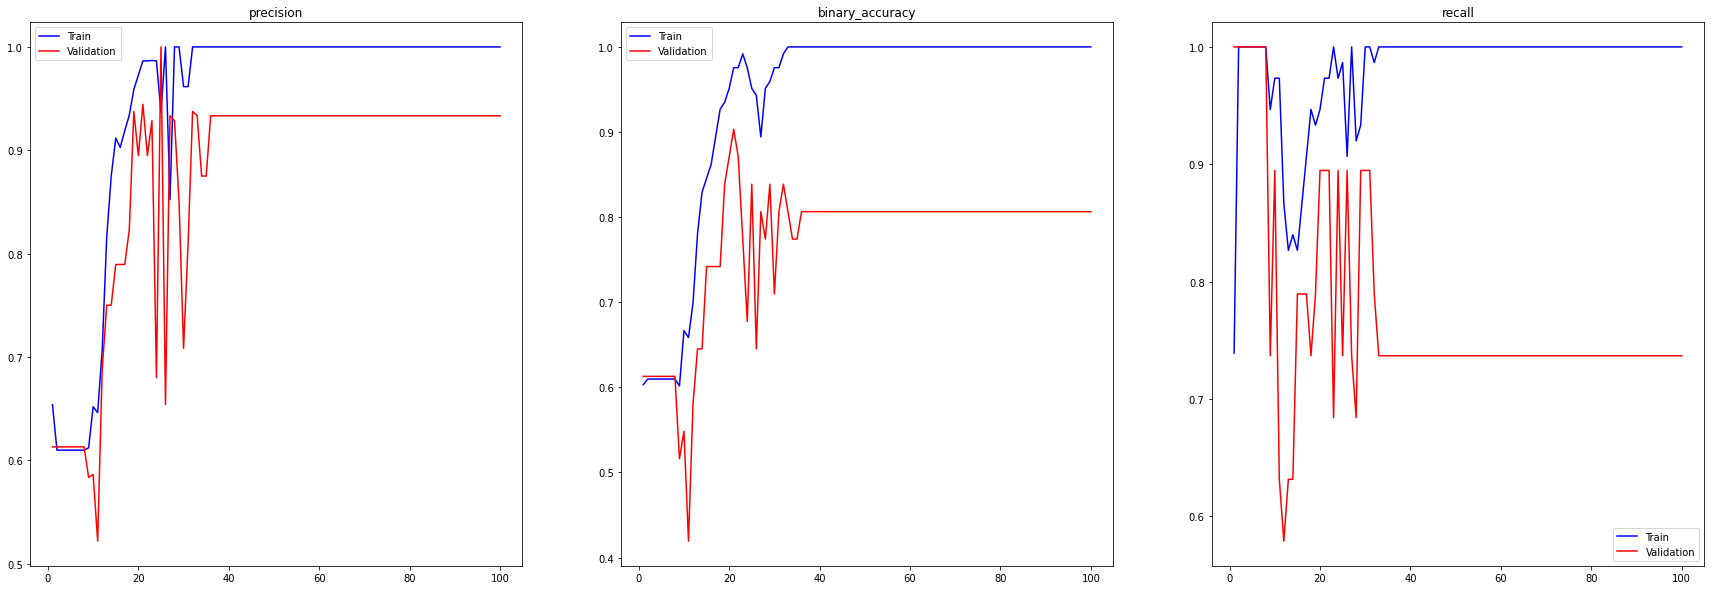

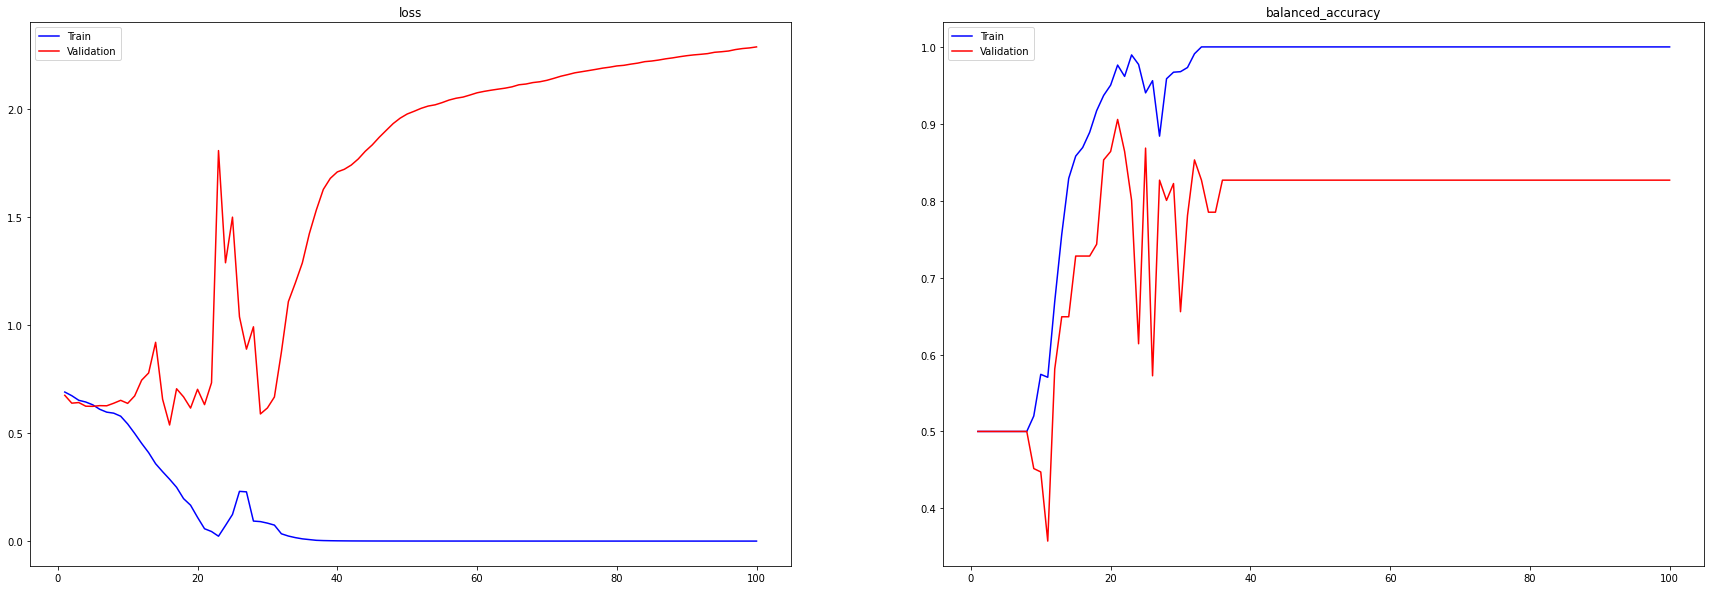

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 2s 328ms/step - loss: 0.7119 - precision: 0.6478 - binary_accuracy: 0.6402 - recall: 0.8957 - balanced_accuracy: 0.5000 - val_loss: 0.6487 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 1s 140ms/step - loss: 0.6431 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6519 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 1s 139ms/step - loss: 0.6200 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6517 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 1s 137ms/step - loss: 0.6014 - precision: 0.6098 - binary_

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.711928,0.647799,0.640212,0.895652,0.5,0.648714,0.612903,0.612903,1.0,0.5
1,0.643144,0.609756,0.609756,1.000000,0.5,0.651851,0.612903,0.612903,1.0,0.5
2,0.620010,0.609756,0.609756,1.000000,0.5,0.651699,0.612903,0.612903,1.0,0.5
3,0.601432,0.609756,0.609756,1.000000,0.5,0.651359,0.612903,0.612903,1.0,0.5
4,0.578632,0.609756,0.609756,1.000000,0.5,0.645852,0.612903,0.612903,1.0,0.5


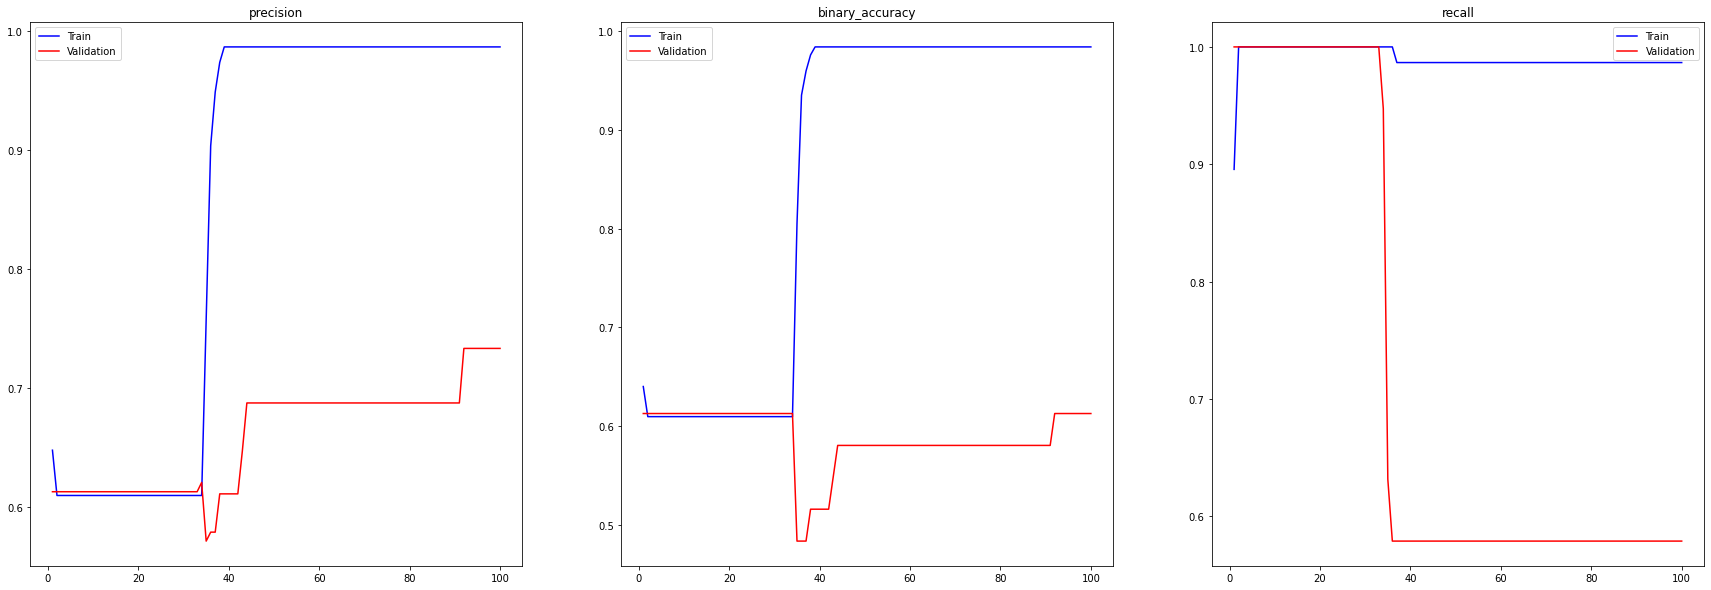

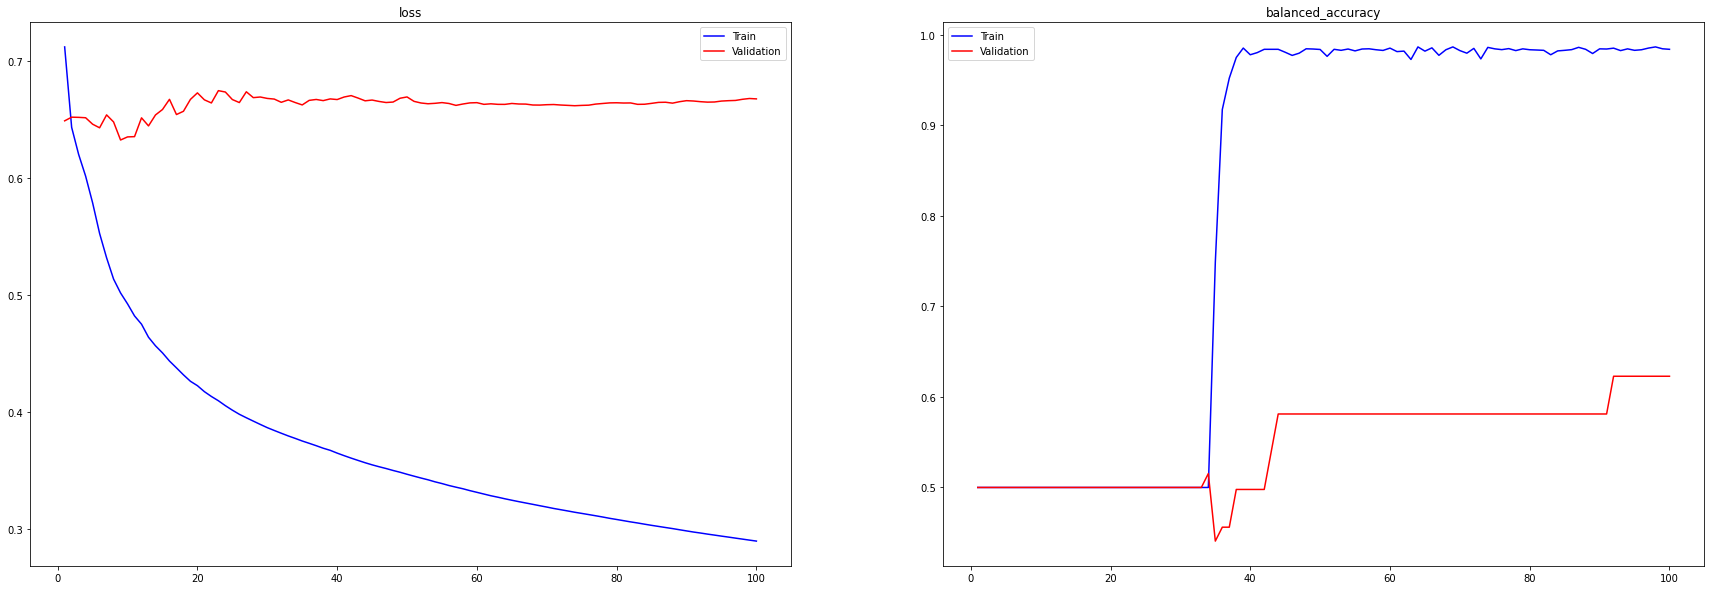

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,1.133698,0.769231,0.712121,0.750,0.486388
VGG-16,8.276082,0.777778,0.696970,0.700,0.638017
Lu-Net,0.673992,0.687500,0.666667,0.825,0.581138


In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

De los resultados graficados hasta el momento, podemos extraer varias conclusiones:

- **Todas las arquitecturas presentan un claro *overfitting***. Se alcanzan valores perfectos de todas las métricas del conjunto de entrenamiento en unas 30-40 iteraciones mientras que las métricas para el conjunto de *validación* quedan "estancadas" en valores entorno al 0.6-0.7. 

- **La función de pérdida aumenta para el conjunto de validación**. Como puede verse, para las tres arquitecturas la función de pérdida para el conjunto de validación comienza a crecer durante las primeras iteraciones, mientras que decrece para el conjunto de entrenamiento. De nuevo, esto sugiere un claro *overfitting* de nuestras redes, pues memorizan las muestras de entrenamiento, siendo incapaces de generalizar y ofrecer buenas predicciones para muestras no vistas.

- 

## DATA AUGMENTATION

In [ ]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [ ]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

N_AUG_NO = 20
N_AUG_YES = np.ceil((N_AUG_NO * X_no.shape[0]) / X_yes.shape[0]).astype(int)
X, classes = data_augmentation_with_class(X, classes, N_AUG_YES, N_AUG_NO, imgs_trans)
X, classes = np.array(X), np.array(classes)

#n_yes = X_yes.shape[0]
#X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], N_AUG_YES, imgs_trans)
#X_yes, y_yes = np.array(X_yes), np.array(y_yes)
#X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG_NO, imgs_trans)
#X_no, y_no = np.array(X_no), np.array(y_no)
#print(f'X_yes shape: {X_yes.shape}')
#print(f'X_no shape: {X_no.shape}')
#X = np.row_stack((X_yes, X_no))
#classes = np.concatenate((y_yes, y_no))

ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
X_tmp = ss.fit_transform(X_tmp)

X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
print(f'X shape: {X.shape}')
print(f'classes shape {classes.shape}')

[!] 50 images agumented...
[!] 100 images agumented...
[!] 150 images agumented...
[!] 200 images agumented...
[!] Total of 220 images augmented!

X shape: (3462, 224, 224)
classes shape (3462,)


In [ ]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1938, 224, 224)
y_train shape (1938,)
X_val shape: (485, 224, 224)
y_val shape (485,)
X_test shape: (1039, 224, 224)
y_test shape: (1039,)


In [ ]:
EPOCHS_2 = 100
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/100
61/61 [==============================] - 5s 82ms/step - loss: 0.5439 - precision: 0.7819 - binary_accuracy: 0.7766 - recall: 0.7632 - balanced_accuracy: 0.7756 - val_loss: 0.3779 - val_precision: 0.8498 - val_binary_accuracy: 0.8309 - val_recall: 0.8082 - val_balanced_accuracy: 0.8163
Epoch 2/100
61/61 [==============================] - 5s 78ms/step - loss: 0.3577 - precision: 0.8505 - binary_accuracy: 0.8442 - recall: 0.8328 - balanced_accuracy: 0.8510 - val_loss: 0.3422 - val_precision: 0.7877 - val_binary_accuracy: 0.8412 - val_recall: 0.9388 - val_balanced_accuracy: 0.8264
Epoch 3/100
61/61 [==============================] - 5s 78ms/step - loss: 0.2818 - precision: 0.8939 - binary_accuracy: 0.8901 - recall: 0.8837 - balanced_accuracy: 0.8882 - val_loss: 0.3146 - val_precision: 0.8500 - val_binary_accuracy: 0.8701 - val_recall: 0.9020 - val_balanced_accuracy: 0.8530
Epoch 4/100
61/61 [==============================] - 5s 78ms/step - loss: 0.2500 - precision: 0.9122 - bin

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.543880,0.781915,0.776574,0.763240,0.775595,0.377877,0.849785,0.830928,0.808163,0.816279
1,0.357680,0.850477,0.844169,0.832814,0.851010,0.342157,0.787671,0.841237,0.938776,0.826421
2,0.281821,0.893908,0.890093,0.883697,0.888162,0.314616,0.850000,0.870103,0.902041,0.852962
3,0.250016,0.912226,0.910217,0.906542,0.909406,0.322016,0.937500,0.870103,0.795918,0.853226
4,0.216039,0.930526,0.925181,0.917965,0.925373,0.307371,0.951456,0.878350,0.800000,0.860654


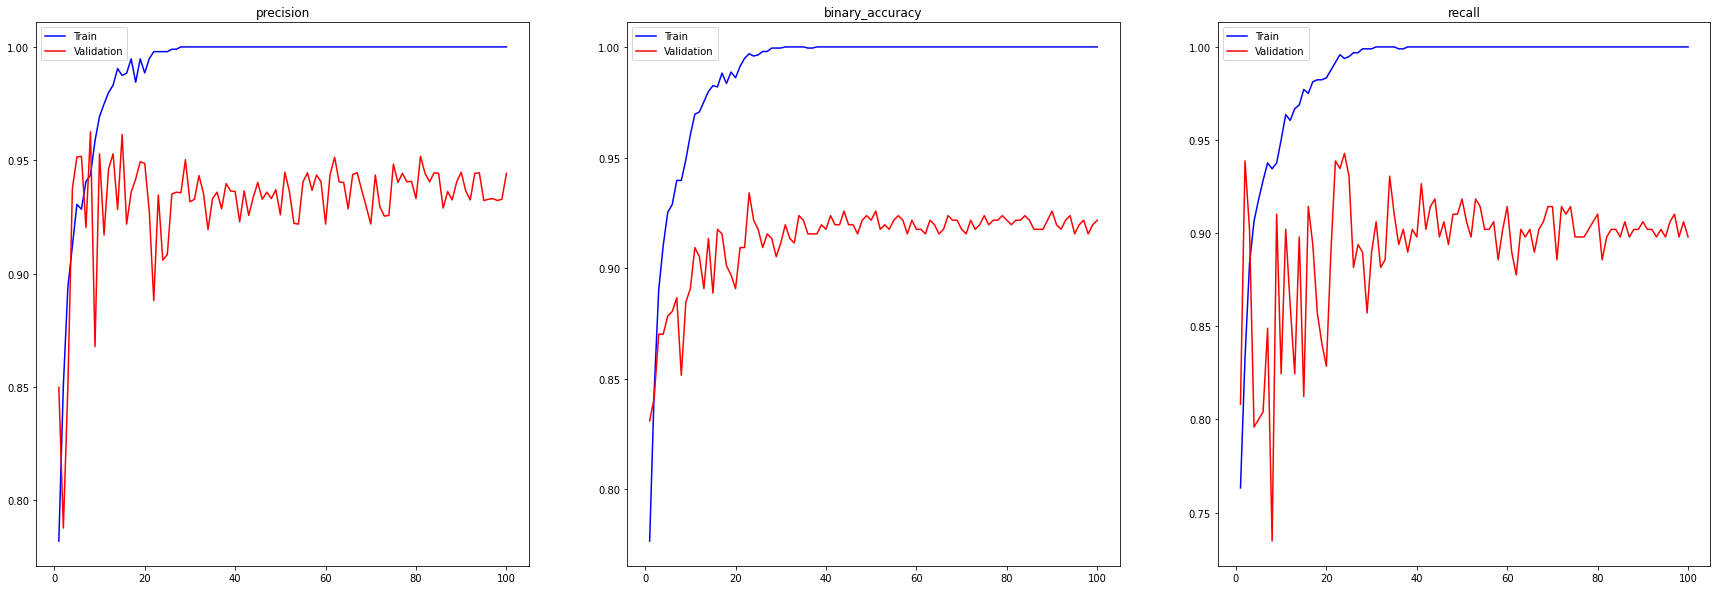

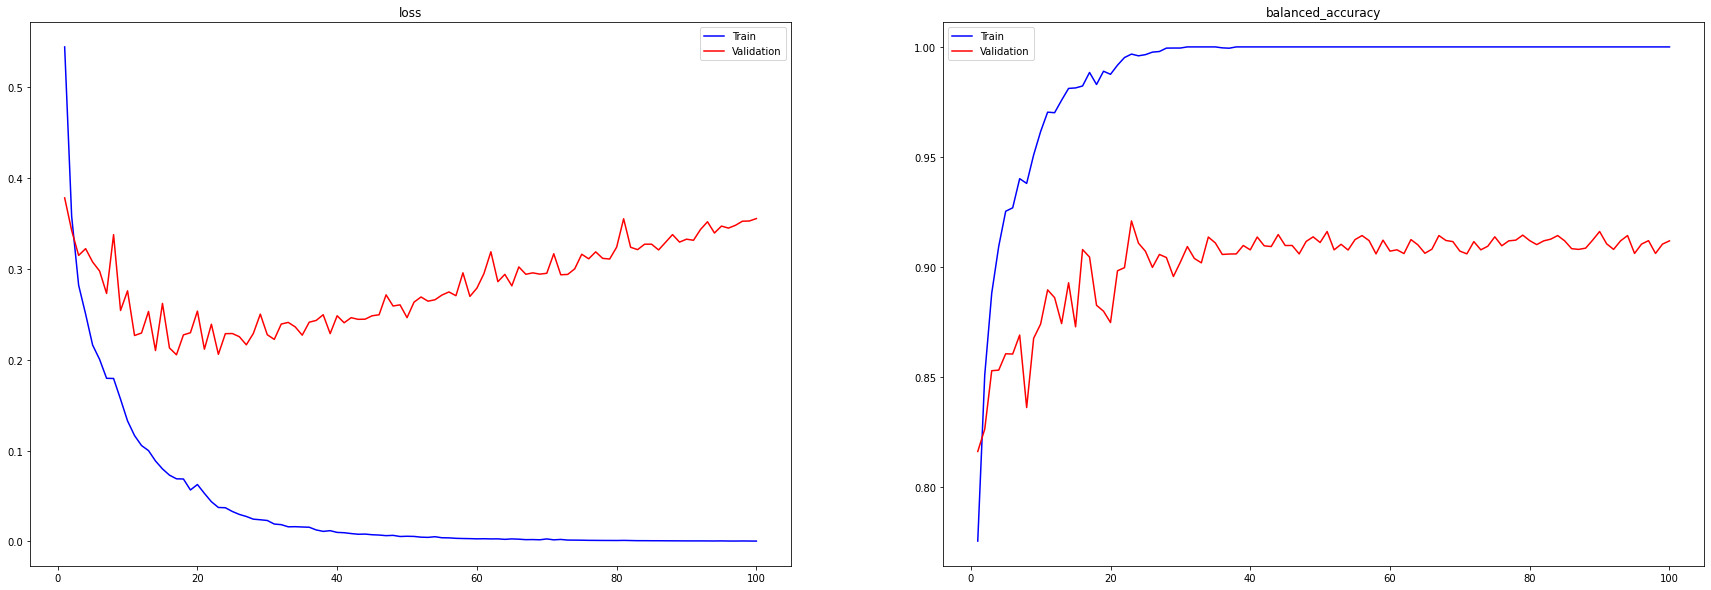

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_2)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_2)

In [ ]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/100
61/61 [==============================] - 10s 169ms/step - loss: 0.6513 - precision: 0.7574 - binary_accuracy: 0.7647 - recall: 0.7747 - balanced_accuracy: 0.7653 - val_loss: 0.3727 - val_precision: 0.8767 - val_binary_accuracy: 0.8474 - val_recall: 0.8122 - val_balanced_accuracy: 0.8378
Epoch 2/100
61/61 [==============================] - 9s 144ms/step - loss: 0.3250 - precision: 0.9006 - binary_accuracy: 0.8689 - recall: 0.8276 - balanced_accuracy: 0.8690 - val_loss: 0.3789 - val_precision: 0.7841 - val_binary_accuracy: 0.8474 - val_recall: 0.9633 - val_balanced_accuracy: 0.8399
Epoch 3/100
61/61 [==============================] - 9s 145ms/step - loss: 0.2179 - precision: 0.9368 - binary_accuracy: 0.9169 - recall: 0.8930 - balanced_accuracy: 0.9167 - val_loss: 0.2535 - val_precision: 0.8509 - val_binary_accuracy: 0.8928 - val_recall: 0.9551 - val_balanced_accuracy: 0.8806
Epoch 4/100
61/61 [==============================] - 9s 144ms/step - loss: 0.1630 - precision: 0.9459 

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.651323,0.757360,0.764706,0.774662,0.765271,0.372677,0.876652,0.847423,0.812245,0.837754
1,0.325041,0.900565,0.868937,0.827622,0.869042,0.378889,0.784053,0.847423,0.963265,0.839867
2,0.217865,0.936819,0.916925,0.893043,0.916662,0.253455,0.850909,0.892784,0.955102,0.880598
3,0.163039,0.945917,0.937048,0.926272,0.934770,0.175655,0.921569,0.938144,0.959184,0.917282
4,0.118276,0.967914,0.954592,0.939772,0.952850,0.164500,0.973913,0.944330,0.914286,0.925170


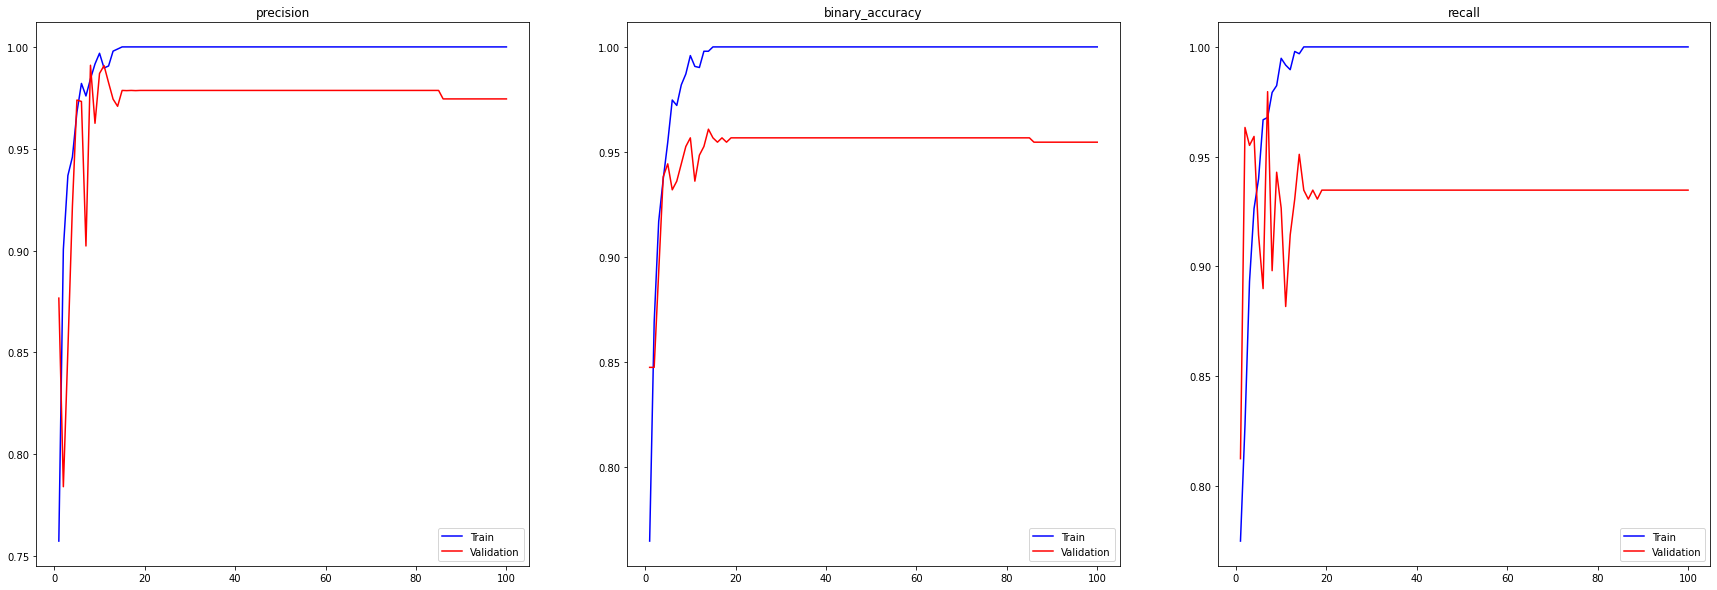

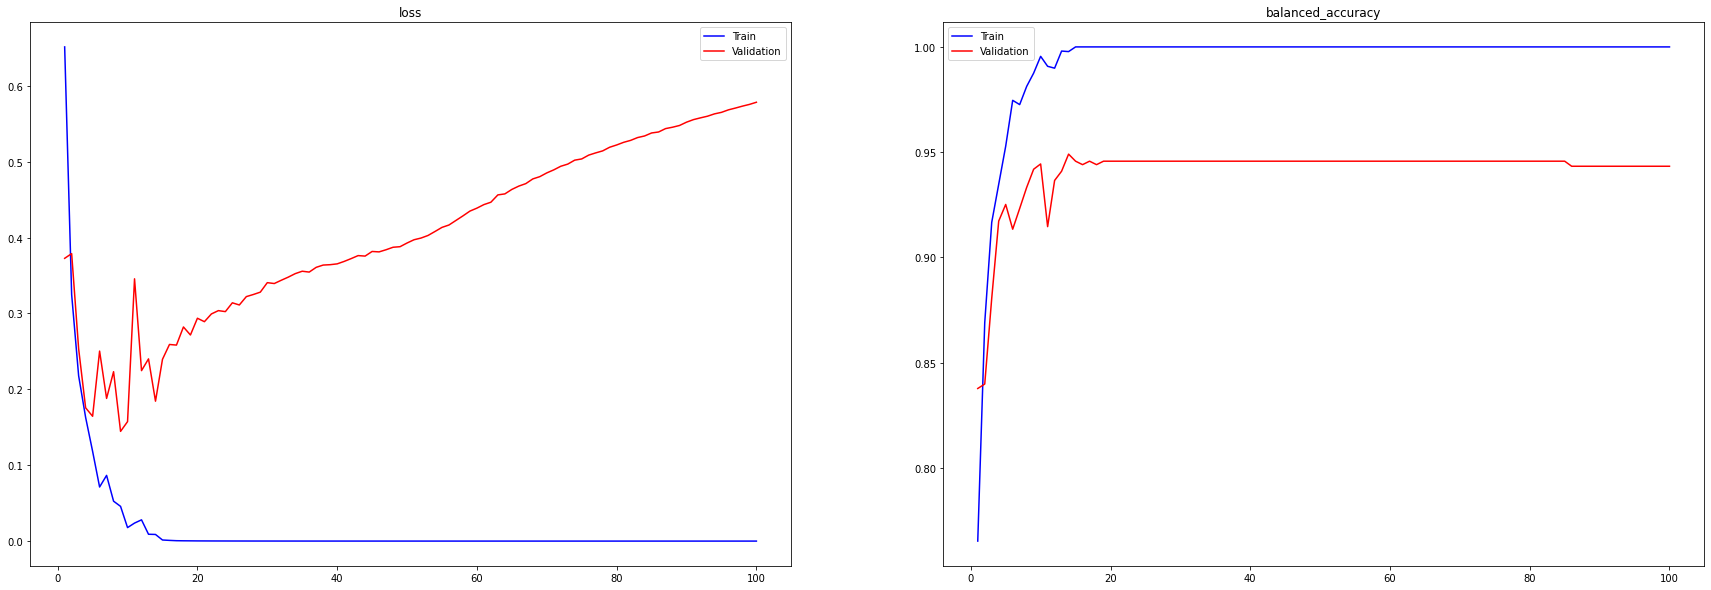

In [ ]:
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_2)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/100
61/61 [==============================] - 8s 136ms/step - loss: 0.6169 - precision: 0.6835 - binary_accuracy: 0.6868 - recall: 0.6885 - balanced_accuracy: 0.6882 - val_loss: 0.5908 - val_precision: 0.7177 - val_binary_accuracy: 0.7175 - val_recall: 0.7265 - val_balanced_accuracy: 0.7222
Epoch 2/100
61/61 [==============================] - 8s 128ms/step - loss: 0.5589 - precision: 0.7416 - binary_accuracy: 0.7337 - recall: 0.7124 - balanced_accuracy: 0.7306 - val_loss: 0.5702 - val_precision: 0.7608 - val_binary_accuracy: 0.7196 - val_recall: 0.6490 - val_balanced_accuracy: 0.7259
Epoch 3/100
61/61 [==============================] - 8s 130ms/step - loss: 0.5220 - precision: 0.8175 - binary_accuracy: 0.7884 - recall: 0.7394 - balanced_accuracy: 0.7900 - val_loss: 0.5477 - val_precision: 0.7671 - val_binary_accuracy: 0.7361 - val_recall: 0.6857 - val_balanced_accuracy: 0.7263
Epoch 4/100
61/61 [==============================] - 8s 129ms/step - loss: 0.4944 - precision: 0.8468 -

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.616905,0.683505,0.686791,0.688474,0.688170,0.590776,0.717742,0.717526,0.726531,0.722160
1,0.558911,0.741622,0.733746,0.712357,0.730624,0.570184,0.760766,0.719588,0.648980,0.725853
2,0.522004,0.817451,0.788442,0.739356,0.790043,0.547717,0.767123,0.736082,0.685714,0.726255
3,0.494414,0.846774,0.813725,0.763240,0.812723,0.519572,0.785714,0.758763,0.718367,0.748471
4,0.472761,0.877647,0.834365,0.774662,0.832798,0.510578,0.782609,0.762887,0.734694,0.752773


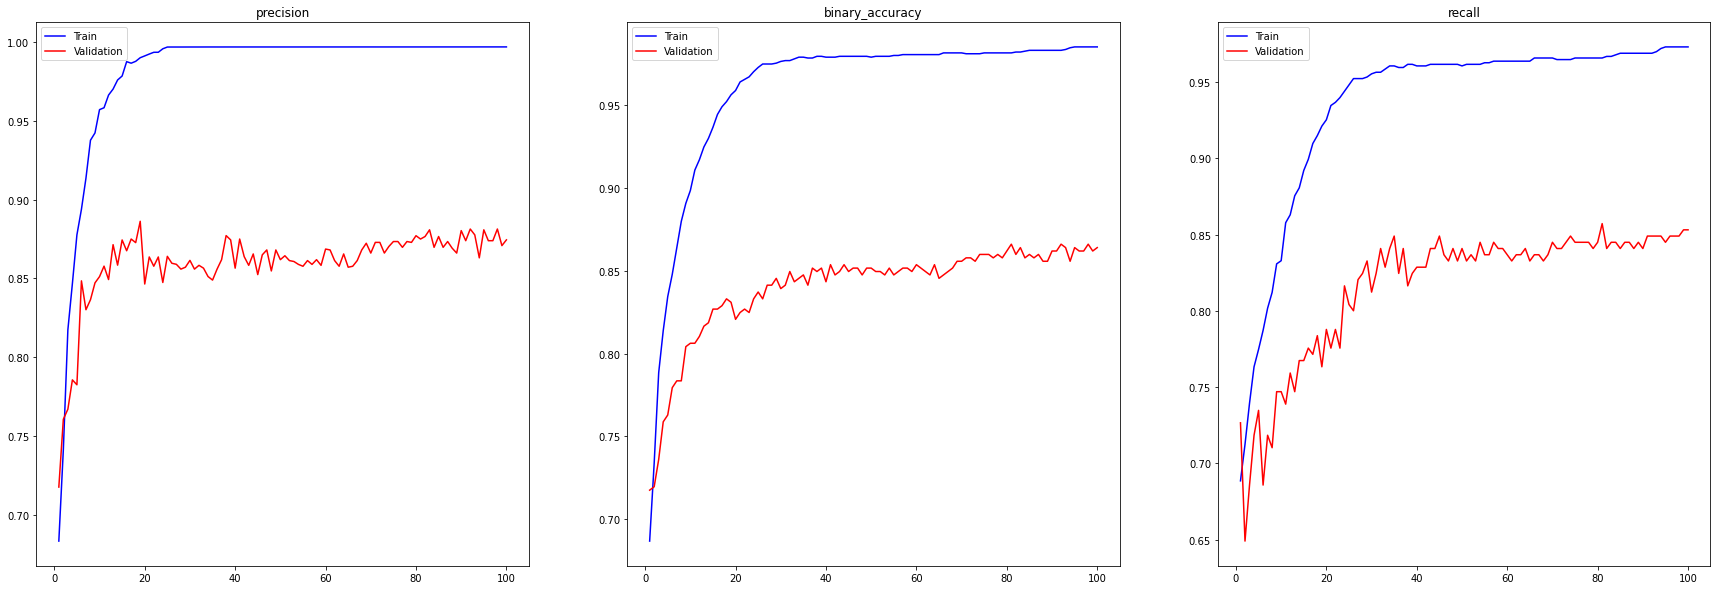

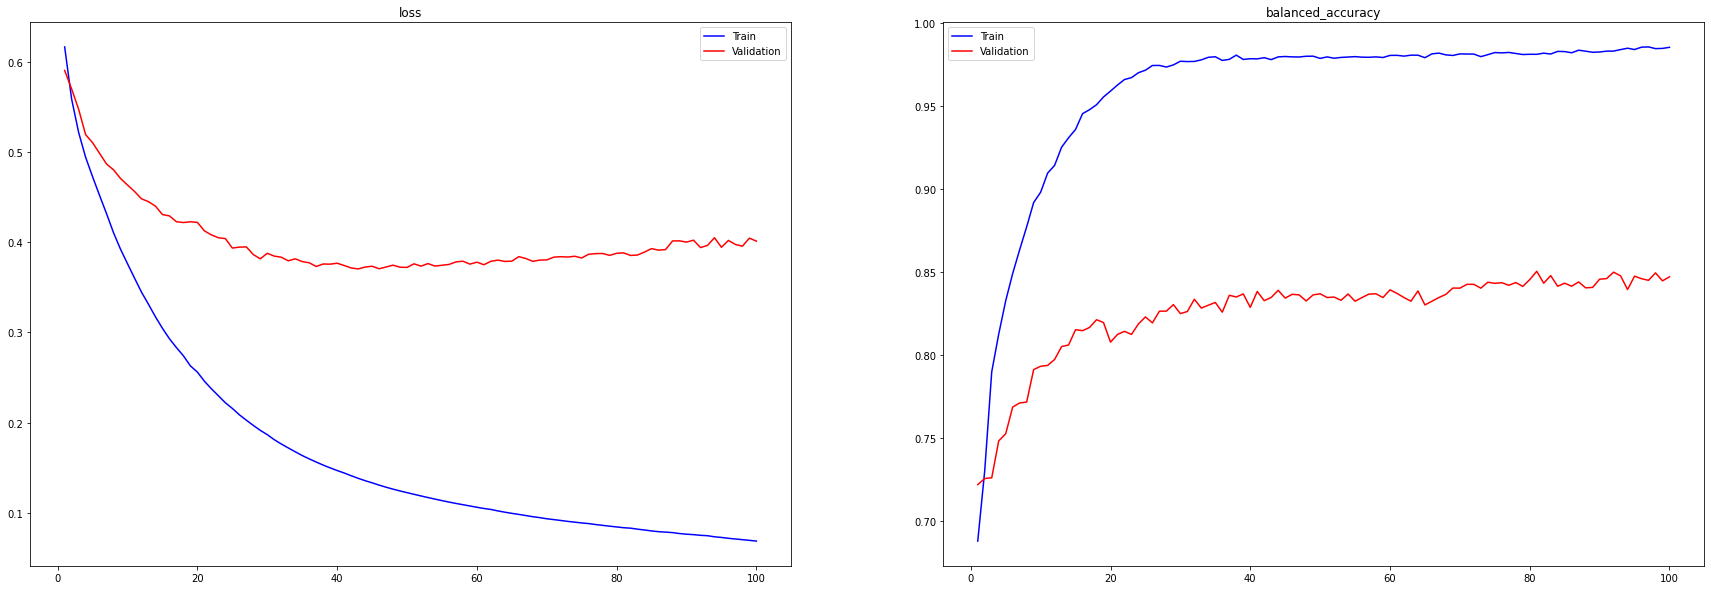

In [ ]:
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_2)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_2)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.420418,0.920792,0.895091,0.870786,0.896876
VGG-16,0.397508,0.975143,0.964389,0.955056,0.964732
Lu-Net,0.473585,0.858546,0.837344,0.818352,0.834635


In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')

## CNNs with L-2 regularization and Dropout layers

In [ ]:
#X_yes, X_no, classes = load_dataset()
#X = np.row_stack((X_yes, X_no))
#N, SIZE_H, SIZE_V = X.shape
#N_CLASSES = len(np.unique(classes))
#print(f'X shape {X.shape}')
#print(f'Num classes: {N_CLASSES}')

In [ ]:
# imgs_trans = A.Compose([
#     A.HorizontalFlip(p=0.25),
#     A.VerticalFlip(p=0.25),
#     A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
#     A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
#     A.Affine(translate_percent=(-0.05, 0.05))
# ])

# N_AUG = 20
# n_yes = X_yes.shape[0]
# X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], 13, imgs_trans)
# X_yes, y_yes = np.array(X_yes), np.array(y_yes)
# X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG, imgs_trans)
# X_no, y_no = np.array(X_no), np.array(y_no)
# print(f'X_yes shape: {X_yes.shape}')
# print(f'X_no shape: {X_no.shape}')
# X = np.row_stack((X_yes, X_no))
# classes = np.concatenate((y_yes, y_no))
# # X, y = data_augmentation(X, classes, N_AUG, imgs_trans)
# # X, y = np.array(X), np.array(y)

# ss = StandardScaler()
# X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
# X_tmp = ss.fit_transform(X_tmp)
# X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
# print(f'X shape: {X.shape}')
# print(f'classes shape {classes.shape}')

In [ ]:
# sd = seed(time())
# X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

# print(f'X_train shape: {X_train.shape}')
# print(f'y_train shape {y_train.shape}')
# print(f'X_val shape: {X_val.shape}')
# print(f'y_val shape {y_val.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_test shape: {y_test.shape}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 112, 112, 32)      832       
                                                                 
 drop_block2d (DropBlock2D)  (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 109, 109, 64)      51264     
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 109, 109, 64)     0         
 )                                                               
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)      

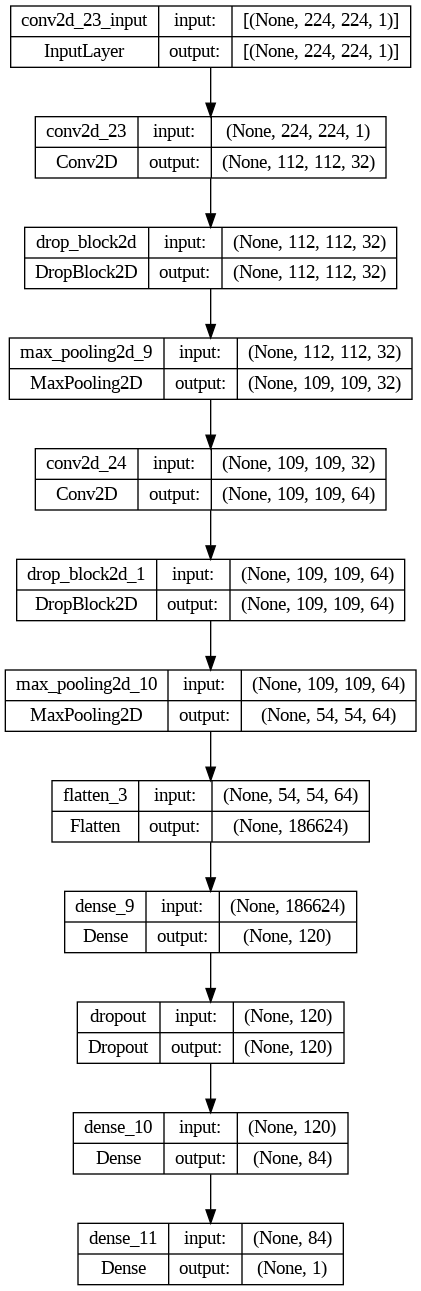

In [ ]:
DROPOUT_RATE = 0.4
DROPBLOCK_RATE = 0.1
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(0.01)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu', kernel_regularizer=L2(0.01)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=84, activation='relu'),
    #Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 drop_block2d_2 (DropBlock2D  (None, 224, 224, 64)     0         
 )                                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 drop_block2d_3 (DropBlock2D  (None, 112, 112, 128)   

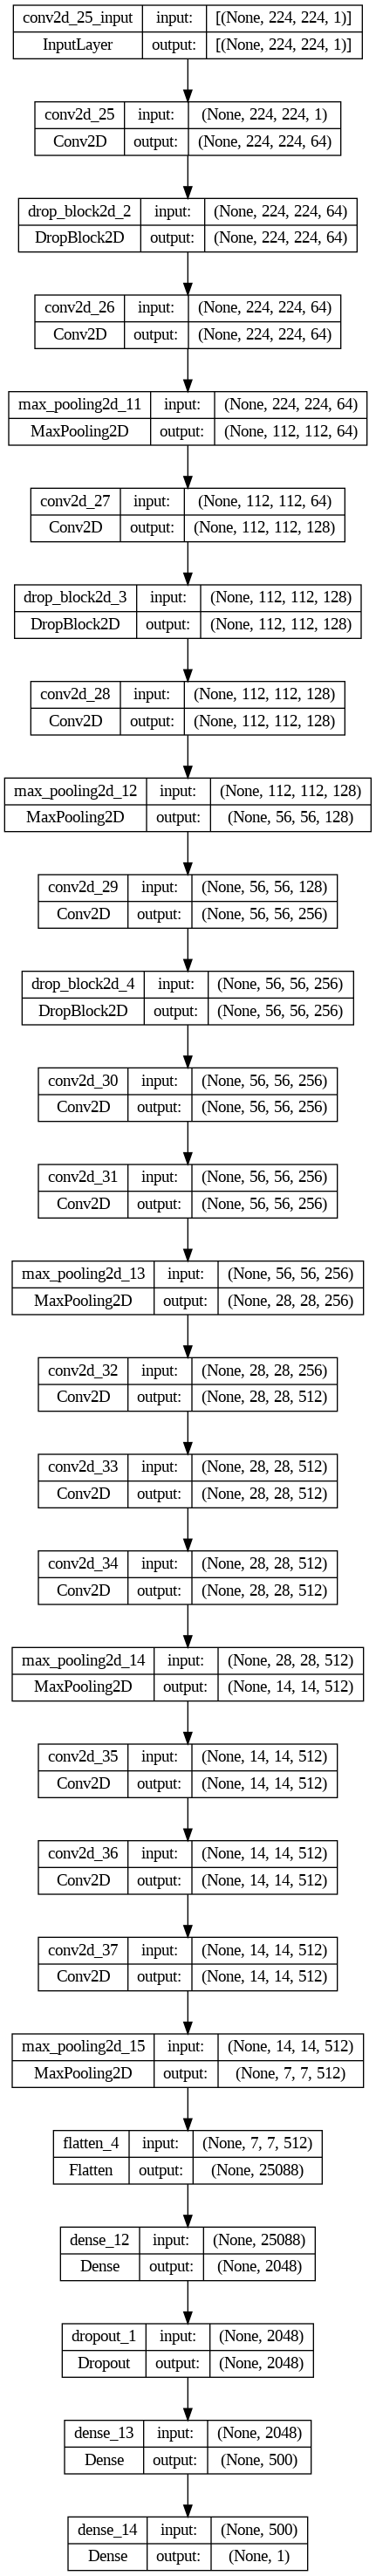

In [ ]:
DROPOUT_RATE = 0.2
DROPBLOCK_RATE = 0.05
# L2_VALUE = 0.0001
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    #DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    #DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=2048, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=500, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 drop_block2d_5 (DropBlock2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_39 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 drop_block2d_6 (DropBlock2D  (None, 112, 112, 64)    

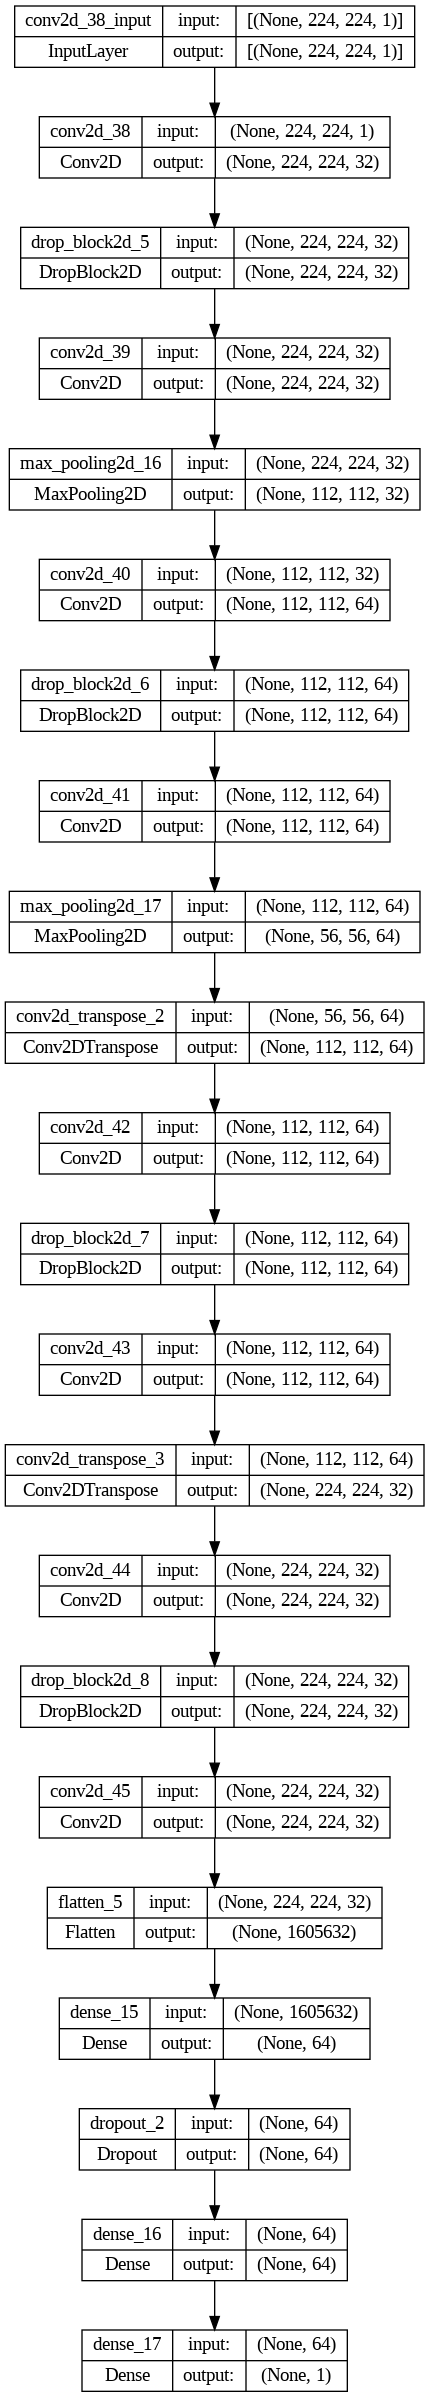

In [ ]:
DROPOUT_RATE = 0.3
DROPBLOCK_RATE = 0.05
L2_VALUE = 0.001
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=64, activation='sigmoid'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=64, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net_dropout.png', show_shapes=True, show_layer_names=True)

In [ ]:
EPOCHS_3 = 100
RES_PATH = './results'
opt = keras.optimizers.Adam(learning_rate=1e-5)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 6s 99ms/step - loss: 1.1037 - precision_1: 0.6166 - binary_accuracy: 0.6146 - recall_1: 0.5929 - balanced_accuracy: 0.6154 - val_loss: 1.0622 - val_precision_1: 0.7128 - val_binary_accuracy: 0.6598 - val_recall_1: 0.5469 - val_balanced_accuracy: 0.6735
Epoch 2/100
61/61 [==============================] - 6s 97ms/step - loss: 1.0365 - precision_1: 0.6783 - binary_accuracy: 0.6765 - recall_1: 0.6636 - balanced_accuracy: 0.6755 - val_loss: 0.9946 - val_precision_1: 0.7123 - val_binary_accuracy: 0.7443 - val_recall_1: 0.8286 - val_balanced_accuracy: 0.7328
Epoch 3/100
61/61 [==============================] - 6s 98ms/step - loss: 0.9649 - precision_1: 0.7464 - binary_accuracy: 0.7497 - recall_1: 0.7518 - balanced_accuracy: 0.7502 - val_loss: 0.9240 - val_precision_1: 0.8143 - val_binary_accuracy: 0.8021 - val_recall_1: 0.7878 - val_balanced_accuracy: 0.7871
Epoch 4/100
61/61 [==============================] - 6s 98ms/step - loss: 0.9109 -

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,1.103737,0.616631,0.614551,0.592939,0.615399,1.062155,0.712766,0.659794,0.546939,0.673489
1,1.036507,0.678344,0.676471,0.663551,0.675539,0.994629,0.712281,0.744330,0.828571,0.732765
2,0.964894,0.746392,0.749742,0.751817,0.750192,0.923984,0.814346,0.802062,0.787755,0.787135
3,0.910939,0.785863,0.786894,0.785047,0.782857,0.888694,0.818182,0.797938,0.771429,0.780843
4,0.875592,0.791967,0.795666,0.798546,0.792777,0.833227,0.862661,0.843299,0.820408,0.828298


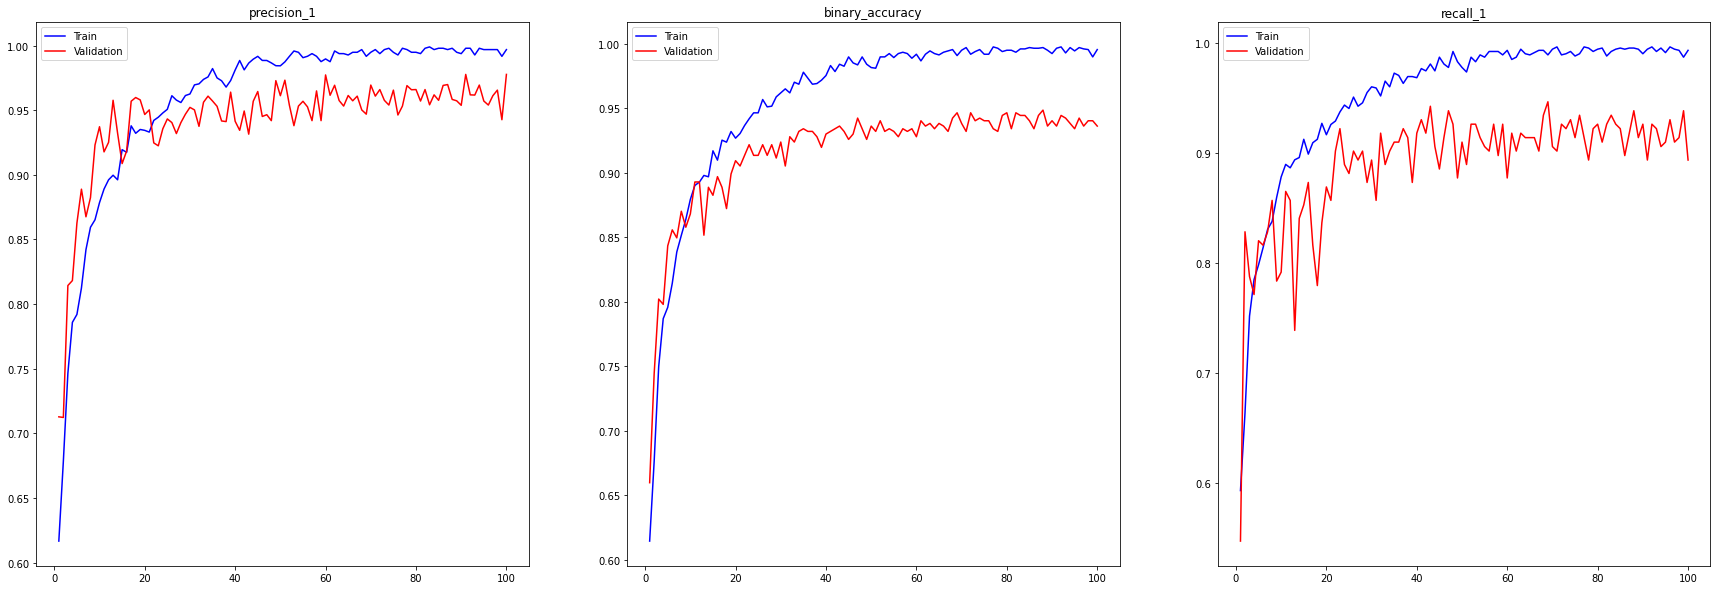

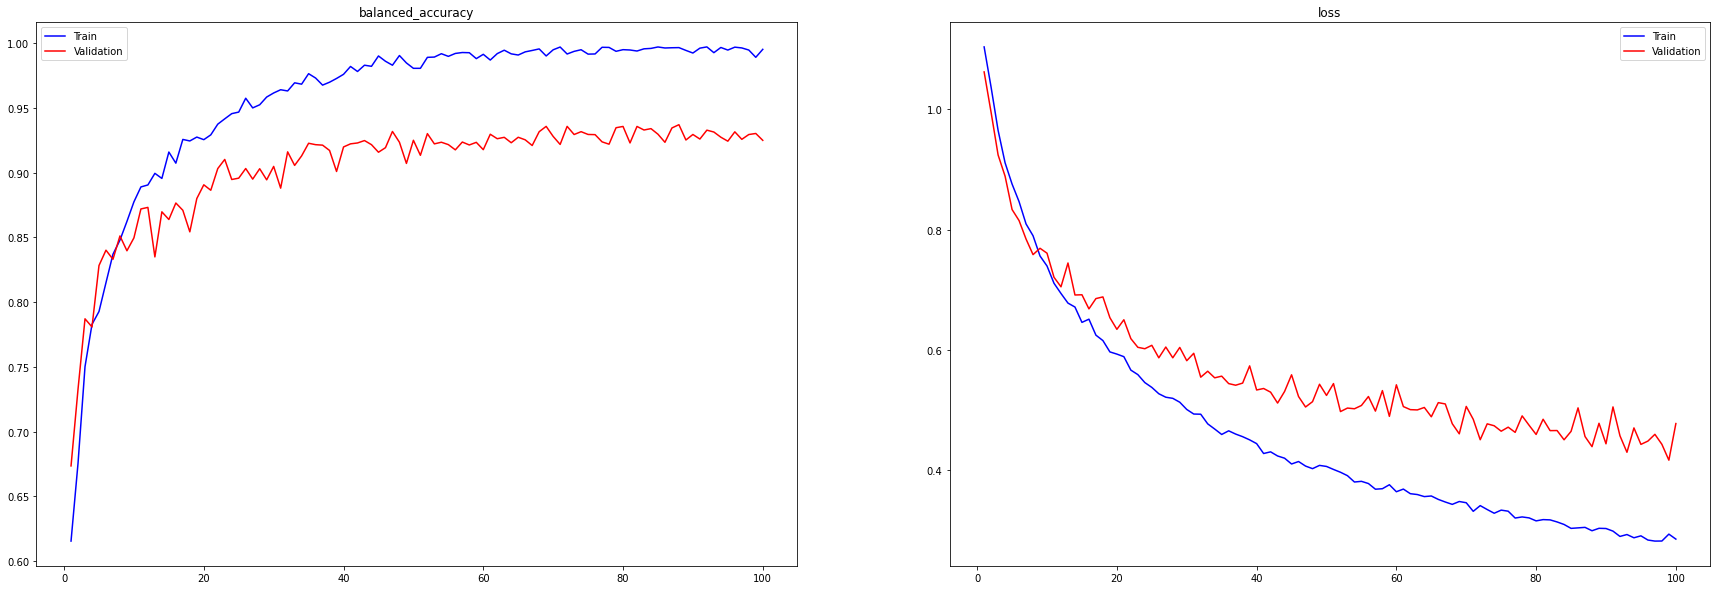

In [ ]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['balanced_accuracy', 'loss']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_3)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_3.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 11s 185ms/step - loss: 0.6834 - precision_1: 0.7333 - binary_accuracy: 0.6970 - recall_1: 0.6246 - balanced_accuracy: 0.5626 - val_loss: 0.6834 - val_precision_1: 0.5385 - val_binary_accuracy: 0.5608 - val_recall_1: 0.9143 - val_balanced_accuracy: 0.5660
Epoch 2/100
61/61 [==============================] - 11s 182ms/step - loss: 0.6281 - precision_1: 0.6722 - binary_accuracy: 0.6754 - recall_1: 0.6771 - balanced_accuracy: 0.6780 - val_loss: 0.5504 - val_precision_1: 0.7449 - val_binary_accuracy: 0.7443 - val_recall_1: 0.7510 - val_balanced_accuracy: 0.7503
Epoch 3/100
61/61 [==============================] - 11s 182ms/step - loss: 0.4713 - precision_1: 0.8203 - binary_accuracy: 0.7771 - recall_1: 0.7061 - balanced_accuracy: 0.7819 - val_loss: 0.4401 - val_precision_1: 0.7854 - val_binary_accuracy: 0.8021 - val_recall_1: 0.8367 - val_balanced_accuracy: 0.8098
Epoch 4/100
61/61 [==============================] - 11s 183ms/step - loss: 

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,0.683399,0.733333,0.697010,0.624582,0.562637,0.683414,0.538462,0.560825,0.914286,0.565976
1,0.628145,0.672165,0.675439,0.677051,0.677952,0.550383,0.744939,0.744330,0.751020,0.750279
2,0.471296,0.820265,0.777090,0.706127,0.781852,0.440084,0.785441,0.802062,0.836735,0.809789
3,0.338647,0.885135,0.856037,0.816199,0.856329,0.244176,0.885375,0.896907,0.914286,0.887028
4,0.244928,0.914621,0.904025,0.889927,0.905779,0.214549,0.893536,0.921649,0.959184,0.909839


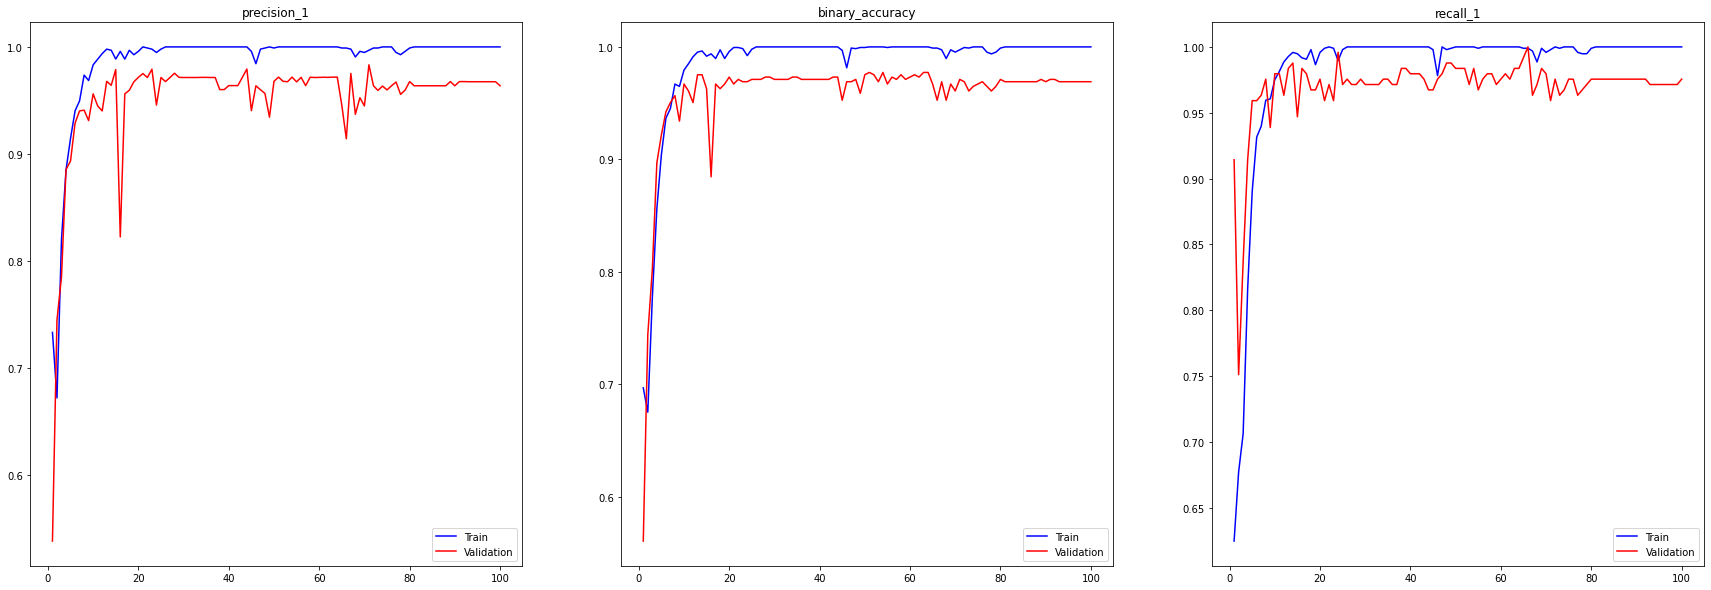

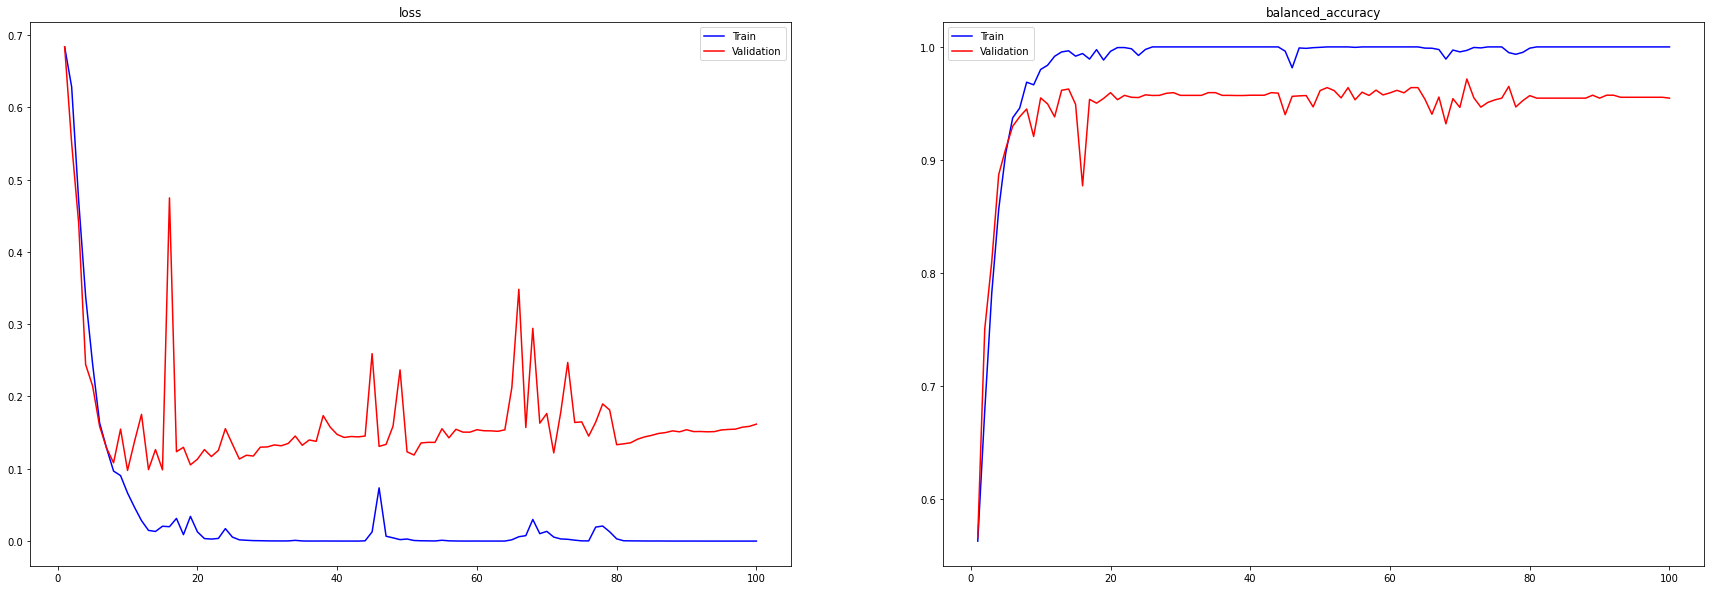

In [ ]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['loss', 'balanced_accuracy']
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_3)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_3.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 10s 171ms/step - loss: 0.6543 - precision_1: 0.7515 - binary_accuracy: 0.7434 - recall_1: 0.7315 - balanced_accuracy: 0.6200 - val_loss: 0.6034 - val_precision_1: 0.7391 - val_binary_accuracy: 0.7216 - val_recall_1: 0.6939 - val_balanced_accuracy: 0.7249
Epoch 2/100
61/61 [==============================] - 10s 168ms/step - loss: 0.5737 - precision_1: 0.7401 - binary_accuracy: 0.7348 - recall_1: 0.7186 - balanced_accuracy: 0.7340 - val_loss: 0.5636 - val_precision_1: 0.7198 - val_binary_accuracy: 0.7278 - val_recall_1: 0.7551 - val_balanced_accuracy: 0.7294
Epoch 3/100
61/61 [==============================] - 10s 168ms/step - loss: 0.5276 - precision_1: 0.7966 - binary_accuracy: 0.7905 - recall_1: 0.7767 - balanced_accuracy: 0.7887 - val_loss: 0.5248 - val_precision_1: 0.8095 - val_binary_accuracy: 0.7897 - val_recall_1: 0.7633 - val_balanced_accuracy: 0.7764
Epoch 4/100
61/61 [==============================] - 10s 168ms/step - loss: 

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,0.654293,0.751544,0.743366,0.731463,0.619999,0.603414,0.739130,0.721649,0.693878,0.724944
1,0.573746,0.740107,0.734778,0.718588,0.733960,0.563636,0.719844,0.727835,0.755102,0.729397
2,0.527640,0.796592,0.790506,0.776739,0.788654,0.524830,0.809524,0.789691,0.763265,0.776390
3,0.481635,0.832983,0.830237,0.823468,0.832313,0.499681,0.806867,0.789691,0.767347,0.776255
4,0.436876,0.876582,0.871517,0.862928,0.871418,0.462498,0.855932,0.841237,0.824490,0.827413


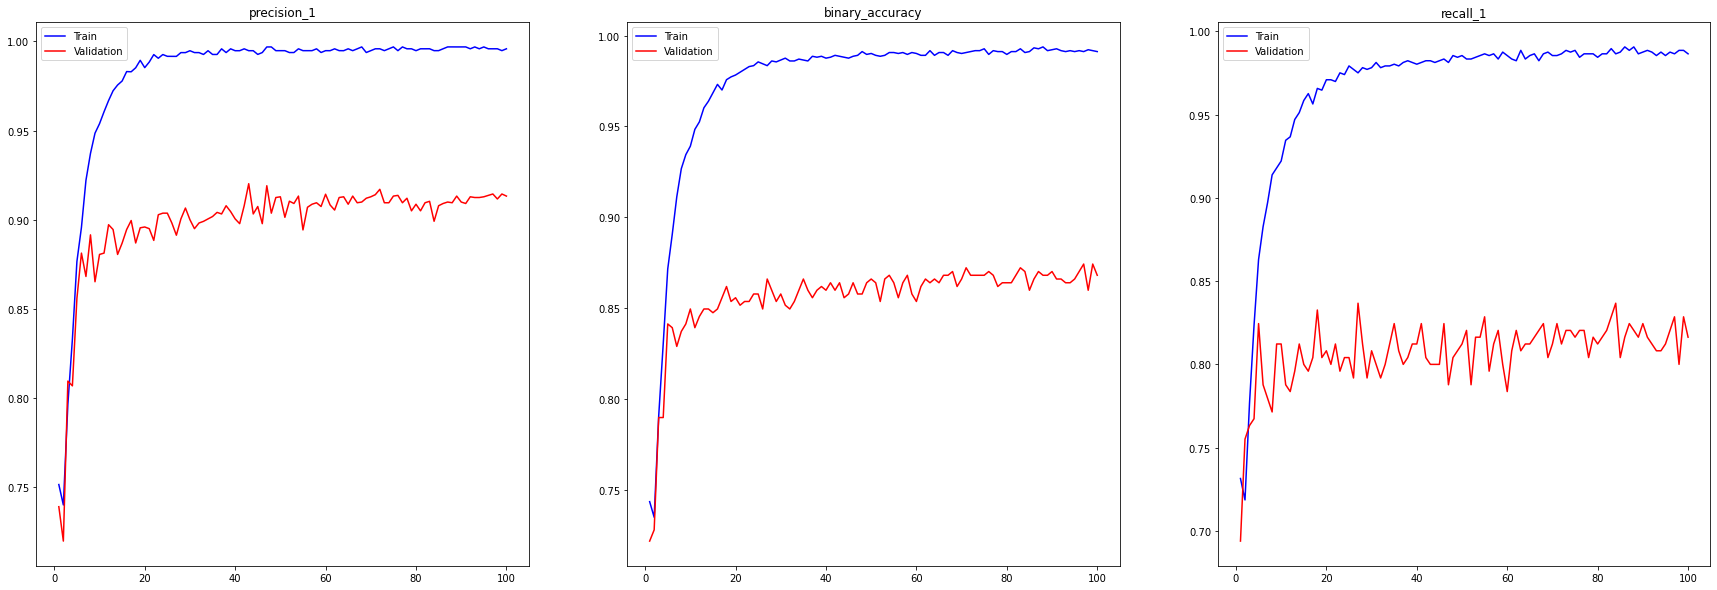

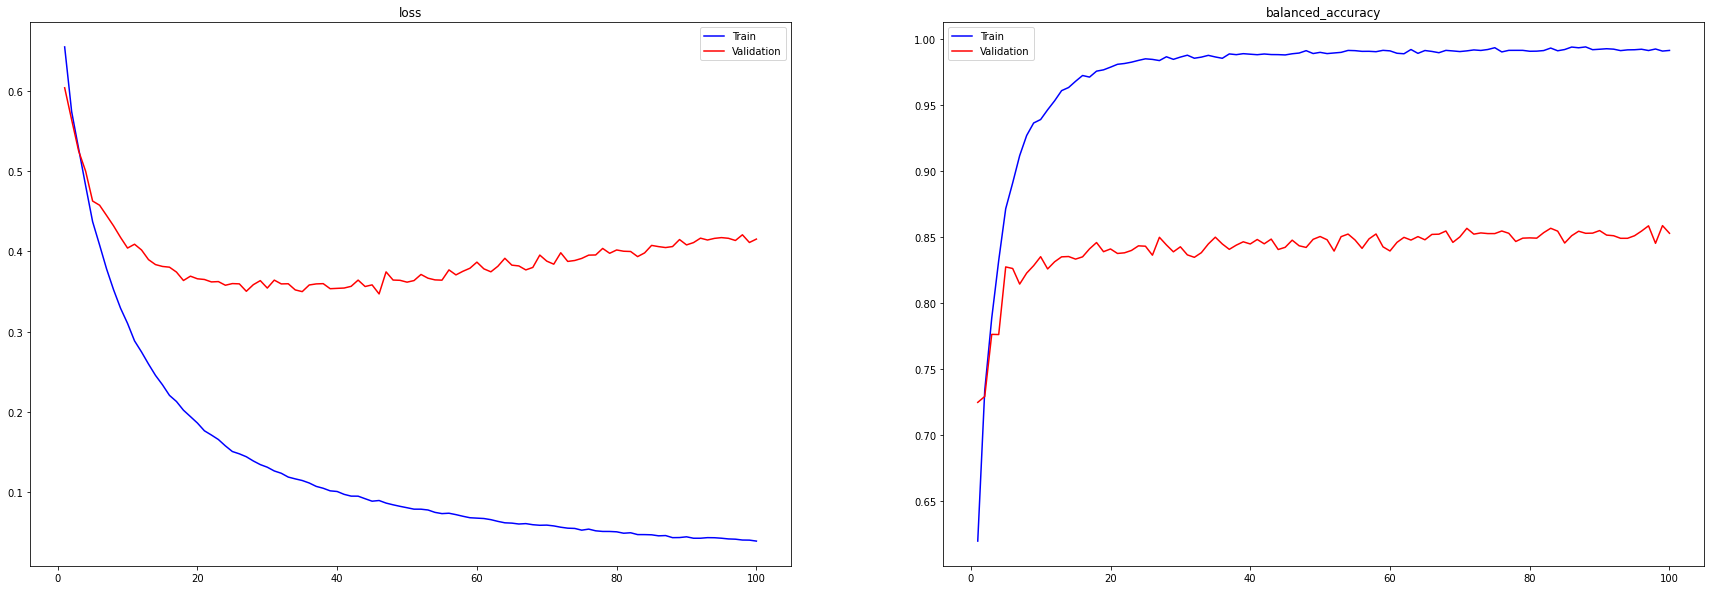

In [ ]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['loss', 'balanced_accuracy']
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_3)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_3.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.498209,0.967280,0.925890,0.885768,0.927673
VGG-16,0.116071,0.979284,0.975938,0.973783,0.977635
Lu-Net,0.553931,0.863636,0.824832,0.782772,0.824033


In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_3.csv')

## More data augmentation and regularization

In [ ]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [ ]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

N_AUG_NO = 40
N_AUG_YES = np.ceil((N_AUG_NO * X_no.shape[0]) / X_yes.shape[0]).astype(int)
X, classes = data_augmentation_with_class(X, classes, N_AUG_YES, N_AUG_NO, imgs_trans)
X, classes = np.array(X), np.array(classes)

#n_yes = X_yes.shape[0]
#X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], N_AUG_YES, imgs_trans)
#X_yes, y_yes = np.array(X_yes), np.array(y_yes)
#X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG_NO, imgs_trans)
#X_no, y_no = np.array(X_no), np.array(y_no)
#print(f'X_yes shape: {X_yes.shape}')
#print(f'X_no shape: {X_no.shape}')
#X = np.row_stack((X_yes, X_no))
#classes = np.concatenate((y_yes, y_no))

ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
X_tmp = ss.fit_transform(X_tmp)

X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
print(f'X shape: {X.shape}')
print(f'classes shape {classes.shape}')

[!] 50 images agumented...
[!] 100 images agumented...
[!] 150 images agumented...
[!] 200 images agumented...
[!] Total of 220 images augmented!

X shape: (6924, 224, 224)
classes shape (6924,)


In [ ]:
#sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3876, 224, 224)
y_train shape (3876,)
X_val shape: (970, 224, 224)
y_val shape (970,)
X_test shape: (2078, 224, 224)
y_test shape: (2078,)


In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
122/122 [==============================] - 12s 99ms/step - loss: 0.4696 - precision_1: 0.9260 - binary_accuracy: 0.9221 - recall_1: 0.9194 - balanced_accuracy: 0.9239 - val_loss: 0.4122 - val_precision_1: 0.9672 - val_binary_accuracy: 0.9474 - val_recall_1: 0.9247 - val_balanced_accuracy: 0.9473
Epoch 2/100
122/122 [==============================] - 12s 96ms/step - loss: 0.4157 - precision_1: 0.9435 - binary_accuracy: 0.9394 - recall_1: 0.9363 - balanced_accuracy: 0.9402 - val_loss: 0.3817 - val_precision_1: 0.9800 - val_binary_accuracy: 0.9526 - val_recall_1: 0.9226 - val_balanced_accuracy: 0.9524
Epoch 3/100
122/122 [==============================] - 12s 96ms/step - loss: 0.3763 - precision_1: 0.9565 - binary_accuracy: 0.9541 - recall_1: 0.9526 - balanced_accuracy: 0.9534 - val_loss: 0.3618 - val_precision_1: 0.9683 - val_binary_accuracy: 0.9639 - val_recall_1: 0.9582 - val_balanced_accuracy: 0.9631
Epoch 4/100
122/122 [==============================] - 12s 95ms/step - lo

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,0.469602,0.926040,0.922085,0.919429,0.923866,0.412184,0.967177,0.947423,0.924686,0.947308
1,0.415739,0.943474,0.939371,0.936257,0.940246,0.381694,0.980000,0.952577,0.922594,0.952416
2,0.376327,0.956477,0.954076,0.952575,0.953382,0.361752,0.968288,0.963918,0.958159,0.963122
3,0.351991,0.964652,0.962074,0.960224,0.962356,0.357928,0.943320,0.958763,0.974895,0.958122
4,0.343242,0.963886,0.964654,0.966344,0.964099,0.343089,0.972399,0.965979,0.958159,0.965227


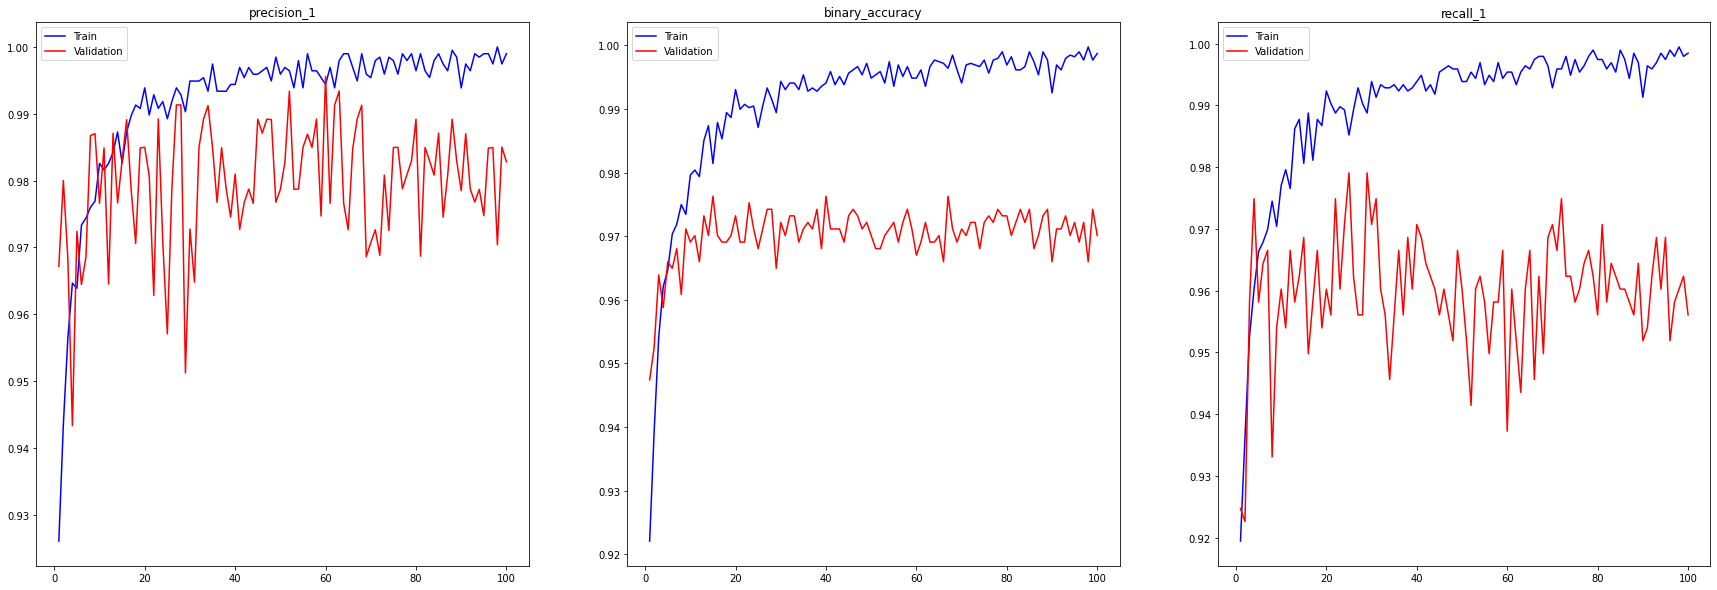

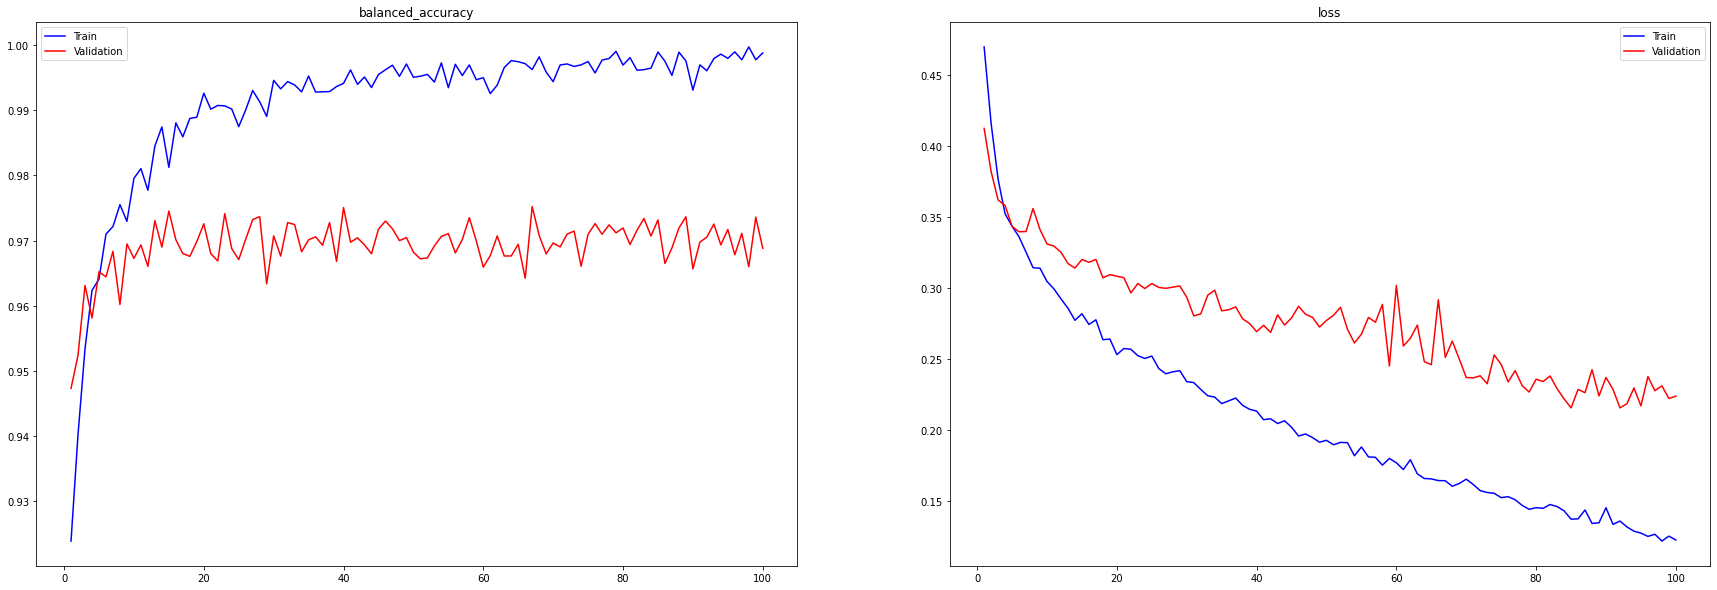

In [ ]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['balanced_accuracy', 'loss']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_3)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_4.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
122/122 [==============================] - 23s 191ms/step - loss: 0.1124 - precision_1: 0.9672 - binary_accuracy: 0.9644 - recall_1: 0.9623 - balanced_accuracy: 0.9646 - val_loss: 0.0560 - val_precision_1: 0.9892 - val_binary_accuracy: 0.9763 - val_recall_1: 0.9623 - val_balanced_accuracy: 0.9761
Epoch 2/100
122/122 [==============================] - 22s 183ms/step - loss: 0.0436 - precision_1: 0.9882 - binary_accuracy: 0.9863 - recall_1: 0.9847 - balanced_accuracy: 0.9868 - val_loss: 0.0601 - val_precision_1: 0.9693 - val_binary_accuracy: 0.9794 - val_recall_1: 0.9895 - val_balanced_accuracy: 0.9801
Epoch 3/100
122/122 [==============================] - 22s 183ms/step - loss: 0.0252 - precision_1: 0.9913 - binary_accuracy: 0.9910 - recall_1: 0.9908 - balanced_accuracy: 0.9891 - val_loss: 0.0847 - val_precision_1: 0.9483 - val_binary_accuracy: 0.9722 - val_recall_1: 0.9979 - val_balanced_accuracy: 0.9724
Epoch 4/100
122/122 [==============================] - 22s 183ms/step 

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,0.112411,0.967196,0.964396,0.962264,0.964603,0.056009,0.989247,0.976289,0.962343,0.976069
1,0.043565,0.988229,0.986326,0.984702,0.986792,0.060134,0.969262,0.979381,0.989540,0.980087
2,0.025248,0.991327,0.990970,0.990821,0.989127,0.084694,0.948310,0.972165,0.997908,0.972391
3,0.024728,0.991833,0.991228,0.990821,0.991341,0.046738,0.991435,0.980412,0.968619,0.981308
4,0.006640,0.997960,0.997936,0.997960,0.997931,0.036938,0.989474,0.986598,0.983264,0.986848


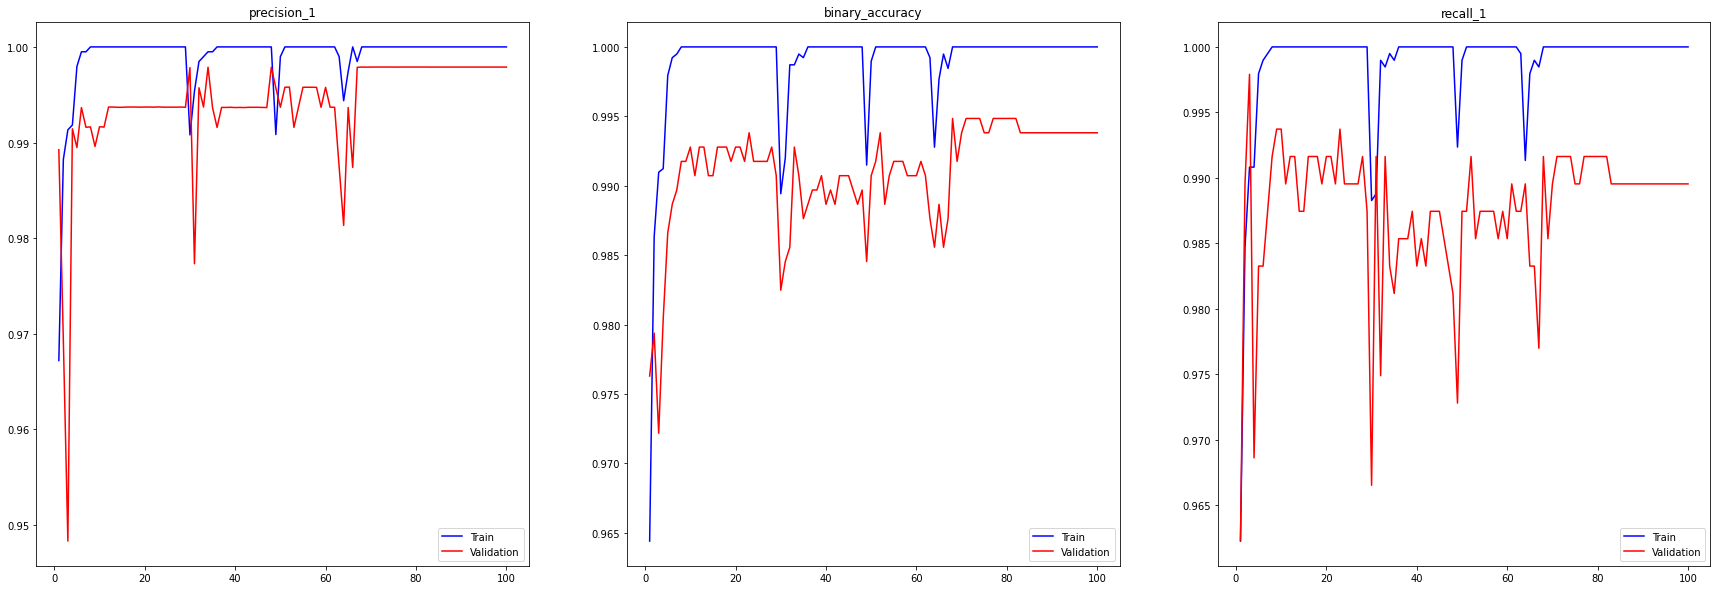

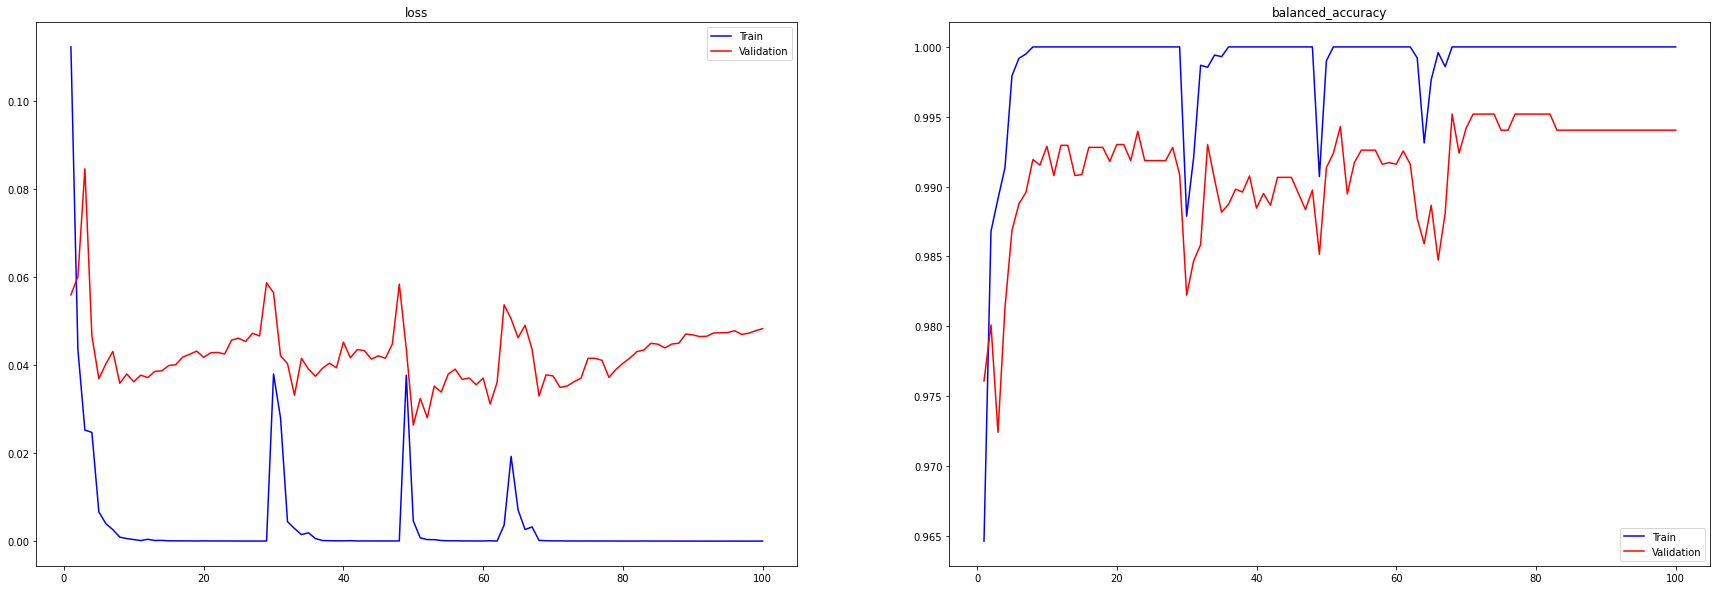

In [ ]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['loss', 'balanced_accuracy']
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_3)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_4.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
122/122 [==============================] - 21s 171ms/step - loss: 0.3643 - precision_1: 0.8546 - binary_accuracy: 0.8452 - recall_1: 0.8363 - balanced_accuracy: 0.8464 - val_loss: 0.3246 - val_precision_1: 0.8909 - val_binary_accuracy: 0.8691 - val_recall_1: 0.8368 - val_balanced_accuracy: 0.8712
Epoch 2/100
122/122 [==============================] - 20s 168ms/step - loss: 0.2779 - precision_1: 0.9028 - binary_accuracy: 0.8937 - recall_1: 0.8853 - balanced_accuracy: 0.8946 - val_loss: 0.2983 - val_precision_1: 0.8860 - val_binary_accuracy: 0.8773 - val_recall_1: 0.8619 - val_balanced_accuracy: 0.8790
Epoch 3/100
122/122 [==============================] - 20s 167ms/step - loss: 0.2422 - precision_1: 0.9220 - binary_accuracy: 0.9100 - recall_1: 0.8980 - balanced_accuracy: 0.9106 - val_loss: 0.2919 - val_precision_1: 0.9226 - val_binary_accuracy: 0.8897 - val_recall_1: 0.8473 - val_balanced_accuracy: 0.8911
Epoch 4/100
122/122 [==============================] - 20s 167ms/step 

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,0.364335,0.854612,0.845201,0.836308,0.846445,0.324591,0.890869,0.869072,0.836820,0.871246
1,0.277851,0.902756,0.893705,0.885263,0.894636,0.298331,0.886021,0.877320,0.861925,0.878955
2,0.242156,0.921990,0.909959,0.898011,0.910562,0.291861,0.922551,0.889691,0.847280,0.891101
3,0.212794,0.930498,0.922343,0.914839,0.924987,0.275487,0.916115,0.895876,0.868201,0.896625
4,0.187535,0.947095,0.938855,0.931158,0.938593,0.272638,0.937355,0.895876,0.845188,0.897093


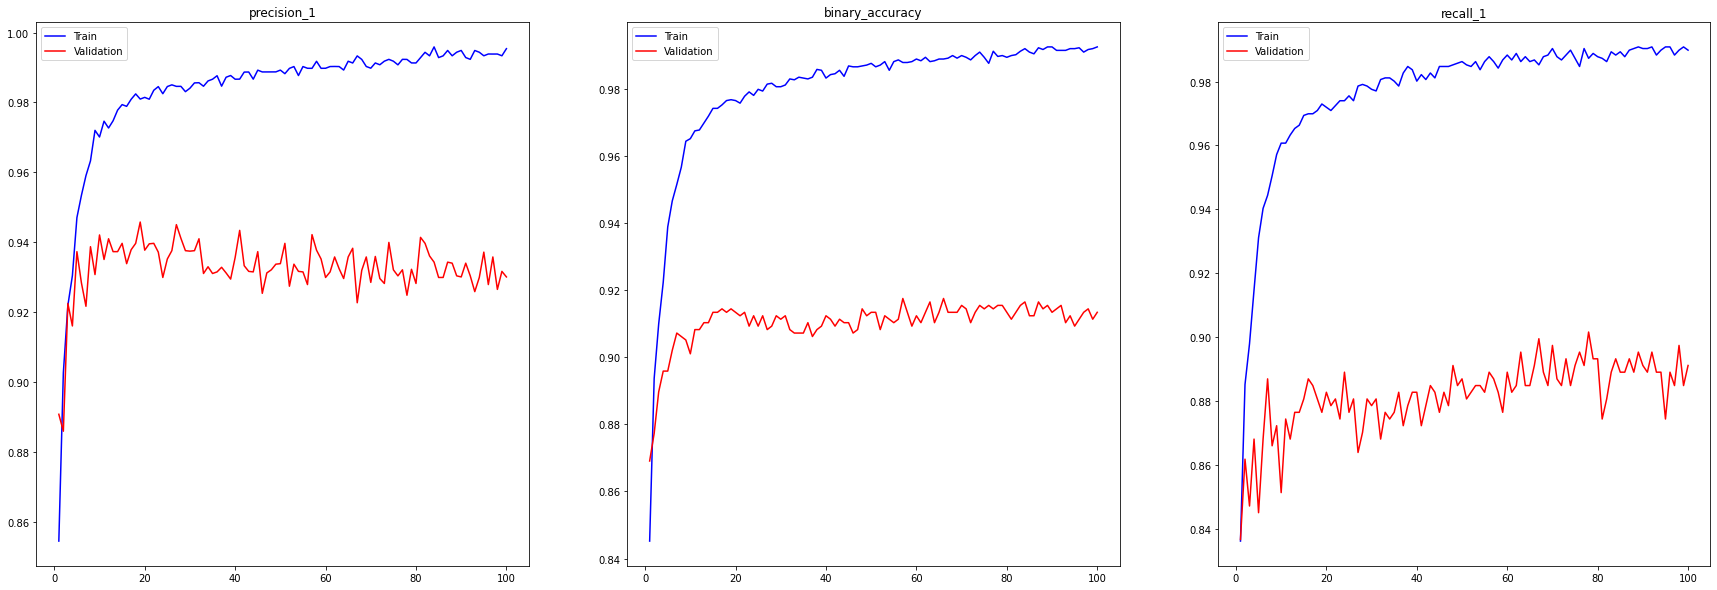

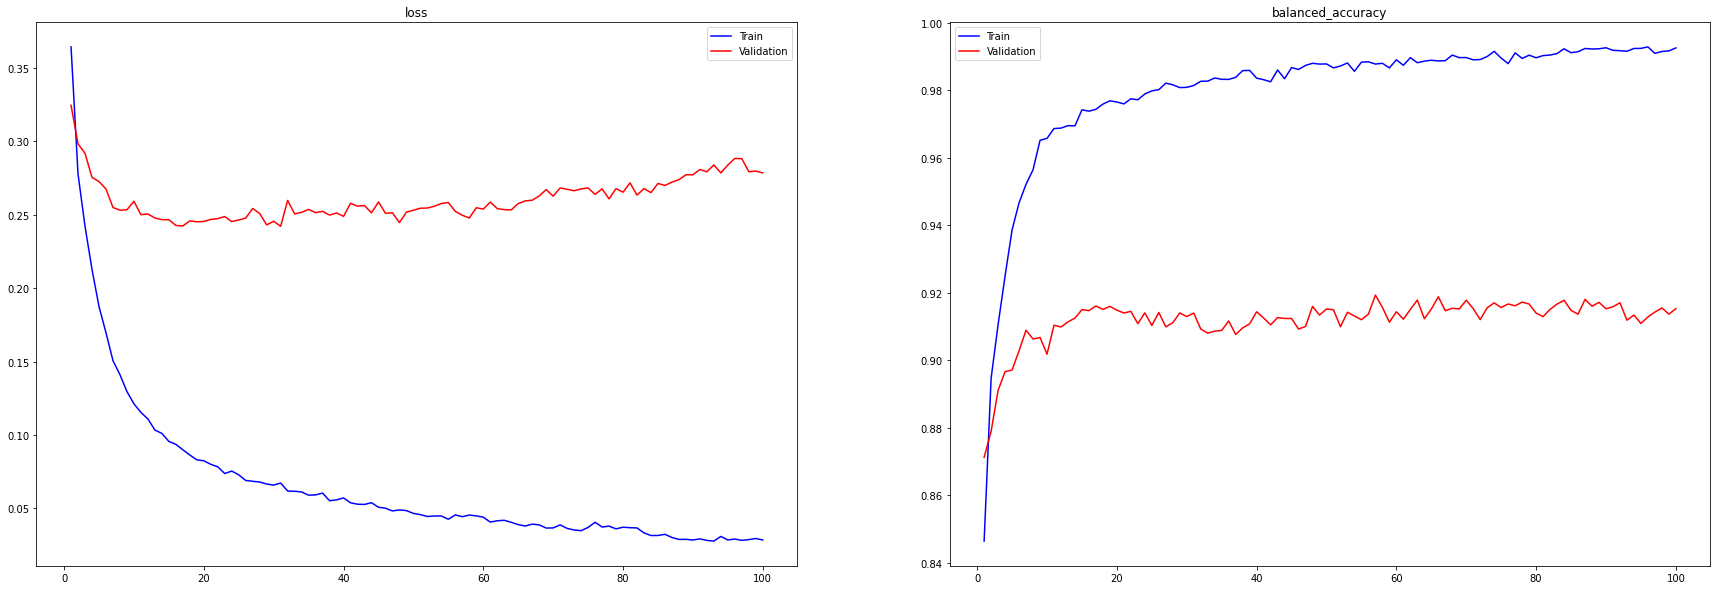

In [ ]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['loss', 'balanced_accuracy']
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_3)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_4.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.203519,0.985352,0.975457,0.965550,0.975840
VGG-16,0.062879,0.992278,0.987969,0.983732,0.987856
Lu-Net,0.309138,0.932392,0.909528,0.884211,0.909004


In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_4.csv')